In [1]:
#Importing the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

#Importing libraries necessary to train the model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler #For normalisation of continuous data
from sklearn.preprocessing import OneHotEncoder #For one-hot encoding of host sex, continent and presence/absence of genes
from sklearn.preprocessing import LabelEncoder #For encoding the phenotype
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression #Baseline model
from sklearn.metrics import (
    classification_report, roc_curve, auc, precision_recall_curve, 
    average_precision_score, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTENC

from probatus.feature_elimination import EarlyStoppingShapRFECV

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm
from xgboost import XGBClassifier

import seaborn as sns
from scipy import stats

import shap

import warnings
warnings.filterwarnings("ignore")

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading the dataset
data = pd.read_excel("../data/final_dataset.xlsx",
                     sheet_name="Sheet1")
df = data.copy()

#Moving the Label column [Phenotype] to the end of the dataset
temp_cols = df.columns.tolist()
index = df.columns.get_loc("Phenotype")
new_cols = temp_cols[0:index] + temp_cols[index+1:] + temp_cols[index:index+1]
df = df[new_cols]

#Formatting the dataset
df['Continent'] = df['Continent'].replace('America','South America')
df['Phenotype'] = df['Phenotype'].replace({'Gastric cancer ' : 'Gastric cancer', 'Non-gastric cancer ' : 'Non-gastric cancer', 'non-gastric cancer ' : 'Non-gastric cancer' })
df['Sex'] = df['Sex'].str.title()
df.drop(df.index[(df['Sex'] == 'Not Applicable')],axis=0,inplace=True)

In [4]:
X, y = df.iloc[:,1:-1], df.iloc[:,-1] #Splitting the dataframe into Features and Labels

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=26) #Splitting the dataframe into 80% training and 20% test set through StratifiedShuffleSplit
for train_index,test_index in sss.split(X,y):
  X_train_set = X.iloc[train_index]
  y_train_set = y.iloc[train_index]
  X_test_set = X.iloc[test_index]
  y_test_set = y.iloc[test_index]

In [5]:
### Preprocessing the training set

le = LabelEncoder() # Label encoding the Labels in the training set
scaler = MinMaxScaler() # Normalising the continuous data in the training set
encoder = OneHotEncoder(sparse_output=False, handle_unknown="error") # One-hot encoding the categorical data in the training set

y_train_set_encoded = le.fit_transform(y_train_set) # Encoding the labels

numeric_cols = X_train_set.select_dtypes(include=['int64', 'float64']).columns # Selecting the numerical columns
X_train_set[numeric_cols] = scaler.fit_transform(X_train_set[numeric_cols]) # Applying MinMaxScaler only to the numeric columns

X_train_set.loc[:, "homB":"vacAs1m1"] = X_train_set.loc[:, "homB":"vacAs1m1"].astype('object') # Converting these columns to object type
categorical_columns = X_train_set.select_dtypes(include=['object']).columns.tolist() # Selecting the categorical columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error") # One-hot encoding the categorical columns
one_hot_encoded = encoder.fit_transform(X_train_set[categorical_columns]) 
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns),
                          index=X_train_set.index) # Creating a DataFrame from the one-hot encoded data

X_train_set_encoded = pd.concat([X_train_set, one_hot_df], axis=1) # Concatenating the one-hot encoded data with the original data

X_train_set_encoded = X_train_set_encoded.drop(categorical_columns, axis=1) # Dropping the original categorical columns
X_train_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"] = X_train_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"].astype('category') # Converting the one-hot encoded columns to category type

In [6]:
### Preprocessing the test set

y_test_set_encoded = le.transform(y_test_set)

numeric_cols_test = X_test_set.select_dtypes(include=['int64', 'float64']).columns # Selecting the numerical columns
X_test_set[numeric_cols_test] = scaler.transform(X_test_set[numeric_cols_test]) # Applying MinMaxScaler only to numeric columns

X_test_set.loc[:, "homB":"vacAs1m1"] = X_test_set.loc[:, "homB":"vacAs1m1"].astype('object') # Converting these columns to object type
categorical_columns_test = X_test_set.select_dtypes(include=['object']).columns.tolist() # Selecting the categorical columns

one_hot_encoded_test = encoder.transform(X_test_set[categorical_columns_test]) # One-hot encoding the categorical columns

one_hot_df_test = pd.DataFrame(one_hot_encoded_test, columns=encoder.get_feature_names_out(categorical_columns_test),
                          index=X_test_set.index) # Creating a DataFrame from the one-hot encoded data

X_test_set_encoded = pd.concat([X_test_set, one_hot_df_test], axis=1) # Concatenating the one-hot encoded data with the original data

X_test_set_encoded = X_test_set_encoded.drop(categorical_columns_test, axis=1) # Dropping the original categorical columns
X_test_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"] = X_test_set_encoded.loc[:, "Sex_Female":"vacAs1m1_1.0"].astype('category') # Converting the one-hot encoded columns to category type

In [7]:
ss = StratifiedShuffleSplit(n_splits=10, random_state=26) # Splitting the dataset into 10 folds for cross-validation

In [8]:
# Logistic Regression

categorical_features = X_train_set_encoded.select_dtypes(include=['category']).columns # Selecting the categorical features
categorical_indices = [X_train_set_encoded.columns.get_loc(col) for col in categorical_features] # Getting the indices of the categorical features for SMOTENC

lr_pipeline = make_pipeline(SMOTENC(categorical_features=categorical_indices,
                                     random_state=26),
                             LogisticRegression(random_state=26)) # Makes a pipeline with SMOTENC and Logistic Regression

lr_pipeline.fit(X_train_set_encoded, y_train_set_encoded) # Fitting the pipeline to the full training set


# y_test_pred = lr_pipeline.predict(X_test_set_encoded) # Get predictions on the test set


# lr_report_dict = classification_report(                 # Generate the classification report as a dictionary
#     le.inverse_transform(y_test_set_encoded),
#     le.inverse_transform(y_test_pred),
#     output_dict=True
# ) 

# lr_report_df = pd.DataFrame(lr_report_dict).transpose() # Convert to DataFrame

# lr_report_df.to_csv("../results/2025-07-07_LR_classification_report.csv", index=True) # Save to CSV

# y_proba_test_0 = lr_pipeline.predict_proba(X_test_set_encoded)[:, 0] # Gastric Cancer
# y_proba_test_1 = lr_pipeline.predict_proba(X_test_set_encoded)[:, 1] # Non-Gastric Cancer
# # ROC Curve
# fpr_0, tpr_0, _ = roc_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
# fpr_1, tpr_1, _ = roc_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)

# roc_auc_0 = auc(fpr_0, tpr_0)
# roc_auc_1 = auc(fpr_1, tpr_1)
# # PR Curve
# precision_0, recall_0, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
# pr_auc_0 = average_precision_score(y_test_set_encoded, y_proba_test_0, pos_label=0, average='weighted')

# precision_1, recall_1, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)
# pr_auc_1 = average_precision_score(y_test_set_encoded, y_proba_test_1, pos_label=1, average='weighted')
# # Plotting
# plt.figure(figsize=(12, 5))

# # ROC Plot
# plt.subplot(1, 2, 1)
# plt.plot(fpr_0, tpr_0, color='blue', label=f"Gastric Cancer AUC = {roc_auc_0:.2f}")
# plt.plot(fpr_1, tpr_1, color='red', label=f"Non-Gastric Cancer AUC = {roc_auc_1:.2f}")
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()

# # PR Plot
# plt.subplot(1, 2, 2)
# plt.plot(recall_0, precision_0, color='green', label=f"Gastric Cancer Avg. Precision = {pr_auc_0:.2f}")
# plt.plot(recall_1, precision_1, color='orange', label=f"Non-Gastric Cancer Avg. Precision = {pr_auc_1:.2f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()

# plt.tight_layout()
# plt.savefig("../results/2025-07-07_LR_roc_pr_curve.png", dpi=1200)
# plt.show()

# # Convert categorical columns to numeric for SHAP
# X_test_set_encoded = X_test_set_encoded.copy()
# for col in X_test_set_encoded.select_dtypes(include=['category']).columns:
#     X_test_set_encoded[col] = X_test_set_encoded[col].cat.codes
# # X_test_set_encoded.dtypes.to_dict()

# # Create SHAP explainer and compute values
# explainer_LR = shap.Explainer(lr_pipeline.named_steps['logisticregression'], X_test_set_encoded)
# shap_values_LR = explainer_LR.shap_values(X_test_set_encoded)

# # Create the summary plot and then save it
# shap.summary_plot(shap_values_LR, X_test_set_encoded,
#                   feature_names=X_test_set_encoded.columns.tolist(), plot_size=(20,10), plot_type="violin", show=False)

# plt.tight_layout()  # Optional: improves layout
# plt.savefig("../results/2025-07-07_LR_shap_summary_plot.png", dpi=1200, bbox_inches='tight')

Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[520, 521, 522, 523, 524, 525,
                                               526, 527, 528, 529, 530, 531,
                                               532, 533, 534, 535, 536, 537,
                                               538, 539, 540, 541, 542, 543,
                                               544, 545, 546, 547],
                         random_state=26)),
                ('logisticregression', LogisticRegression(random_state=26))])

Label mapping detected: {'Gastric cancer': 0, 'Non-gastric cancer': 1}
Positive class 'Gastric cancer' encoded as: 0


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

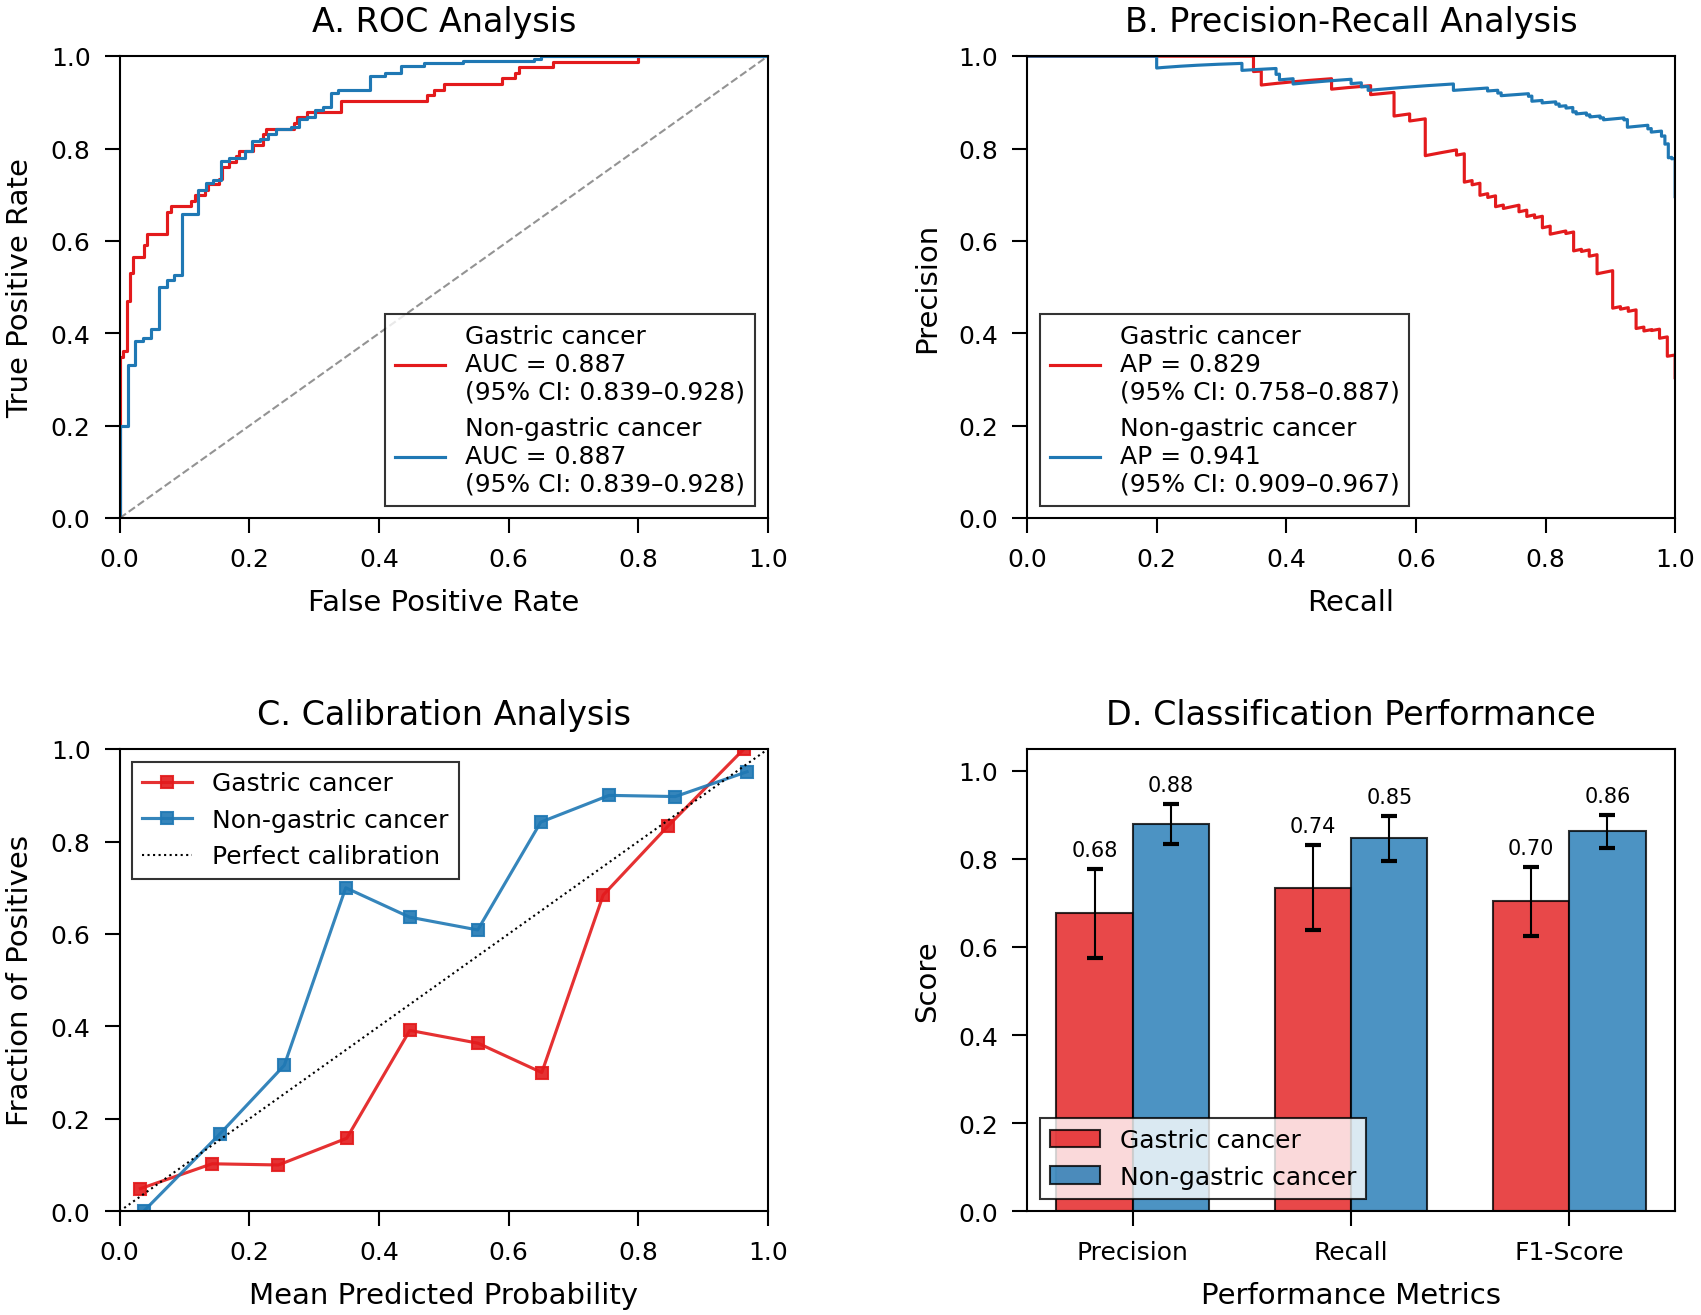

In [13]:
# scripts/evaluate_baseline_lr_model.py - ROBUST VERSION
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, roc_curve, auc, 
                           precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, accuracy_score,
                           confusion_matrix)
from sklearn.calibration import calibration_curve

def determine_label_mapping(label_encoder):
    """
    Determine which class corresponds to which numeric label.
    
    Returns:
    - dict: mapping of {class_name: numeric_label}
    """
    classes = label_encoder.classes_
    mapping = {}
    for i, class_name in enumerate(classes):
        mapping[class_name] = i
    
    return mapping

def get_positive_class_info(label_encoder, positive_class_name="Gastric cancer"):
    """
    Get information about the positive class encoding.
    
    Parameters:
    - label_encoder: fitted LabelEncoder
    - positive_class_name: name of the positive class
    
    Returns:
    - dict with positive class info
    """
    mapping = determine_label_mapping(label_encoder)
    
    return {
        'positive_class_name': positive_class_name,
        'positive_class_label': mapping.get(positive_class_name, None),
        'negative_class_name': [k for k in mapping.keys() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'negative_class_label': [v for k, v in mapping.items() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'full_mapping': mapping
    }

def bootstrap_metric(y_true, y_pred, y_proba, metric_func, n_bootstrap=1000, confidence_level=0.95, **kwargs):
    """Bootstrap confidence intervals for metrics."""
    np.random.seed(42)
    n_size = len(y_true)
    bootstrap_scores = []
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n_size, n_size, replace=True)
        
        if y_proba is not None:
            score = metric_func(y_true[indices], y_proba[indices], **kwargs)
        else:
            score = metric_func(y_true[indices], y_pred[indices], **kwargs)
        
        bootstrap_scores.append(score)
    
    bootstrap_scores = np.array(bootstrap_scores)
    
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_scores, (alpha/2) * 100)
    ci_upper = np.percentile(bootstrap_scores, (1 - alpha/2) * 100)
    
    return {
        'mean': np.mean(bootstrap_scores),
        'std': np.std(bootstrap_scores),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'scores': bootstrap_scores
    }

def evaluate_model(model, X_test, y_test, le, save_path):
    """
    ROBUST evaluation of the logistic regression model with confidence intervals.
    
    Parameters:
    - model: trained logistic regression model
    - X_test: DataFrame, test features  
    - y_test: Series, test labels
    - le: LabelEncoder, fitted label encoder for the labels
    - save_path: str, path to save the evaluation results and figures
    """
    
    # Create directories if they don't exist
    os.makedirs(save_path + "/figures", exist_ok=True)
    
    # Get label mapping information - THIS IS THE KEY IMPROVEMENT
    positive_class_info = get_positive_class_info(le, "Gastric cancer")
    print(f"Label mapping detected: {positive_class_info['full_mapping']}")
    print(f"Positive class 'Gastric cancer' encoded as: {positive_class_info['positive_class_label']}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Original labels for reporting
    y_test_orig = le.inverse_transform(y_test)
    y_pred_orig = le.inverse_transform(y_pred)
    
    # Basic classification report (same as before)
    report_dict = classification_report(y_test_orig, y_pred_orig, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(
        f"{save_path}/LR_classification_report.csv", index=True
    )
    
    # NEW: Calculate metrics with confidence intervals
    pos_class_label = positive_class_info['positive_class_label']
    neg_class_label = positive_class_info['negative_class_label']
    
    # Get probability columns for each class
    y_proba_positive = y_proba[:, pos_class_label]
    y_proba_negative = y_proba[:, neg_class_label]
    
    # Calculate AUC with CI for both classes
    def auc_score_pos(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_class_label)
        return auc(fpr, tpr)
    
    def auc_score_neg(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=neg_class_label)
        return auc(fpr, tpr)
    
    auc_results_pos = bootstrap_metric(y_test, None, y_proba_positive, auc_score_pos)
    auc_results_neg = bootstrap_metric(y_test, None, y_proba_negative, auc_score_neg)
    
    # Calculate AP with CI for both classes  
    def ap_score_pos(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=pos_class_label)
    
    def ap_score_neg(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=neg_class_label)
    
    ap_results_pos = bootstrap_metric(y_test, None, y_proba_positive, ap_score_pos)
    ap_results_neg = bootstrap_metric(y_test, None, y_proba_negative, ap_score_neg)
    
    # NEW: Calculate classification metrics with CI for both classes
    prec_results_pos = bootstrap_metric(y_test, y_pred, None, precision_score, 
                                      pos_label=pos_class_label, average='binary')
    rec_results_pos = bootstrap_metric(y_test, y_pred, None, recall_score, 
                                     pos_label=pos_class_label, average='binary')
    f1_results_pos = bootstrap_metric(y_test, y_pred, None, f1_score, 
                                    pos_label=pos_class_label, average='binary')
    
    prec_results_neg = bootstrap_metric(y_test, y_pred, None, precision_score, 
                                      pos_label=neg_class_label, average='binary')
    rec_results_neg = bootstrap_metric(y_test, y_pred, None, recall_score, 
                                     pos_label=neg_class_label, average='binary')
    f1_results_neg = bootstrap_metric(y_test, y_pred, None, f1_score, 
                                    pos_label=neg_class_label, average='binary')
    
    # Store all results for plotting
    classification_results = {
        positive_class_info['positive_class_name']: {
            'Precision': prec_results_pos,
            'Recall': rec_results_pos,
            'F1-Score': f1_results_pos
        },
        positive_class_info['negative_class_name']: {
            'Precision': prec_results_neg,
            'Recall': rec_results_neg,
            'F1-Score': f1_results_neg
        }
    }
    
    # NEW: Enhanced plotting with confidence intervals
    create_enhanced_lr_plots(y_test, y_proba, save_path, positive_class_info, 
                            auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg,
                            classification_results)

def create_enhanced_lr_plots(y_test, y_proba, save_path, positive_class_info,
                            auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg,
                            classification_results):
    """Create publication-quality plots meeting GigaScience journal standards."""
    
    # GigaScience publication standards
    plt.rcParams.update({           
        'font.size': 7,                   # Minimum readable size (7pt)
        'axes.titlesize': 8,              # Slightly larger for titles
        'axes.labelsize': 7,              # Axis labels
        'xtick.labelsize': 6,             # Tick labels smaller
        'ytick.labelsize': 6,             # Tick labels smaller  
        'legend.fontsize': 6,             # Legend text smaller
        'axes.linewidth': 0.5,            # Line thickness 0.25-1pt
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'lines.linewidth': 0.75,          # Plot line thickness
        'patch.linewidth': 0.5,           # Bar outline thickness
        'figure.dpi': 300,                # 300 DPI for publication
        'savefig.dpi': 300,               # Ensure save DPI
        'savefig.bbox': 'tight',          # Crop white borders
        'savefig.pad_inches': 0.02        # Minimum 2px border
    })
    
    # Figure dimensions for full page width (170mm = 6.69 inches)
    # Height calculated to maintain aspect ratio while staying under 225mm (8.86 inches)
    fig_width = 6.69  # 170mm in inches
    fig_height = 5.0   # Allows room for legend, stays under 225mm limit
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(fig_width, fig_height))
    
    # MODIFICATION: Increase spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.5)  # More space both horizontally and vertically
    
    # Remove main title to save space - individual subplot titles are sufficient
    # fig.suptitle('Logistic Regression Evaluation', fontsize=8, y=0.98)
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Plot 1: ROC Curve with CI
    fpr_pos, tpr_pos, _ = roc_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    fpr_neg, tpr_neg, _ = roc_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax1.plot(fpr_pos, tpr_pos, color='#E31A1C', linewidth=0.75,  # Publication red
            label=f"{pos_name}\nAUC = {auc_results_pos['mean']:.3f}\n(95% CI: {auc_results_pos['ci_lower']:.3f}–{auc_results_pos['ci_upper']:.3f})")
    ax1.plot(fpr_neg, tpr_neg, color='#1F78B4', linewidth=0.75,  # Publication blue
            label=f"{neg_name}\nAUC = {auc_results_neg['mean']:.3f}\n(95% CI: {auc_results_neg['ci_lower']:.3f}–{auc_results_neg['ci_upper']:.3f})")
    ax1.plot([0, 1], [0, 1], linestyle='--', color='#666666', alpha=0.7, linewidth=0.5)
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate") 
    ax1.set_title("A. ROC Analysis")
    ax1.legend(frameon=True, fancybox=False, edgecolor='black')
    # MODIFICATION: Remove grid lines
    # ax1.grid(True, alpha=0.3, linewidth=0.25)  # Commented out to remove grid
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Plot 2: PR Curve with CI
    precision_pos, recall_pos, _ = precision_recall_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    precision_neg, recall_neg, _ = precision_recall_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax2.plot(recall_pos, precision_pos, color='#E31A1C', linewidth=0.75,
            label=f"{pos_name}\nAP = {ap_results_pos['mean']:.3f}\n(95% CI: {ap_results_pos['ci_lower']:.3f}–{ap_results_pos['ci_upper']:.3f})")
    ax2.plot(recall_neg, precision_neg, color='#1F78B4', linewidth=0.75,
            label=f"{neg_name}\nAP = {ap_results_neg['mean']:.3f}\n(95% CI: {ap_results_neg['ci_lower']:.3f}–{ap_results_neg['ci_upper']:.3f})")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("B. Precision-Recall Analysis")
    ax2.legend(frameon=True, fancybox=False, edgecolor='black')
    # MODIFICATION: Remove grid lines
    # ax2.grid(True, alpha=0.3, linewidth=0.25)  # Commented out to remove grid
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    # Plot 3: Calibration Plot
    y_true_pos = (y_test == pos_label).astype(int)
    y_true_neg = (y_test == neg_label).astype(int)
    fraction_pos, mean_pred_pos = calibration_curve(y_true_pos, y_proba[:, pos_label], n_bins=10)
    fraction_neg, mean_pred_neg = calibration_curve(y_true_neg, y_proba[:, neg_label], n_bins=10)
    
    ax3.plot(mean_pred_pos, fraction_pos, "s-", label=f"{pos_name}", alpha=0.9, 
            color='#E31A1C', markersize=3, linewidth=0.75, markeredgewidth=0.5)
    ax3.plot(mean_pred_neg, fraction_neg, "s-", label=f"{neg_name}", alpha=0.9, 
            color='#1F78B4', markersize=3, linewidth=0.75, markeredgewidth=0.5)
    ax3.plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=0.5)
    ax3.set_xlabel("Mean Predicted Probability")
    ax3.set_ylabel("Fraction of Positives")
    ax3.set_title("C. Calibration Analysis")
    ax3.legend(frameon=True, fancybox=False, edgecolor='black')
    # MODIFICATION: Remove grid lines
    # ax3.grid(True, alpha=0.3, linewidth=0.25)  # Commented out to remove grid
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    
    # Plot 4: Classification Metrics Bar Plot with CI
    metrics = ['Precision', 'Recall', 'F1-Score']
    class_names = list(classification_results.keys())
    
    # Extract means and error bars (half of CI width)
    pos_means = [classification_results[class_names[0]][m]['mean'] for m in metrics]
    pos_errors = [(classification_results[class_names[0]][m]['ci_upper'] - 
                   classification_results[class_names[0]][m]['ci_lower'])/2 for m in metrics]
    
    neg_means = [classification_results[class_names[1]][m]['mean'] for m in metrics]
    neg_errors = [(classification_results[class_names[1]][m]['ci_upper'] - 
                   classification_results[class_names[1]][m]['ci_lower'])/2 for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, pos_means, width, yerr=pos_errors, 
                    label=class_names[0], capsize=2, alpha=0.8, color='#E31A1C',
                    linewidth=0.5, edgecolor='black', error_kw={'linewidth': 0.5})
    bars2 = ax4.bar(x + width/2, neg_means, width, yerr=neg_errors, 
                    label=class_names[1], capsize=2, alpha=0.8, color='#1F78B4',
                    linewidth=0.5, edgecolor='black', error_kw={'linewidth': 0.5})
    
    # Add value labels on top of bars (smaller font for space)
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        ax4.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + pos_errors[i] + 0.02,
                f'{pos_means[i]:.2f}', ha='center', va='bottom', fontsize=5)
        ax4.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + neg_errors[i] + 0.02,
                f'{neg_means[i]:.2f}', ha='center', va='bottom', fontsize=5)
    
    ax4.set_xlabel('Performance Metrics')
    ax4.set_ylabel('Score')
    ax4.set_title('D. Classification Performance')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend(frameon=True, fancybox=False, edgecolor='black')
    # MODIFICATION: Remove grid lines
    # ax4.grid(True, alpha=0.3, linewidth=0.25)  # Commented out to remove grid
    ax4.set_ylim(0, 1.05)  # Slight headroom for labels
    
    # Note: tight_layout is commented out because we're using subplots_adjust for more control
    # plt.tight_layout(pad=0.3)  # Minimal padding
    
    # Save in multiple formats for journal submission
    # High resolution PNG for web/review
    fig.savefig(f"{save_path}/figures/LR_ROC_PR.png", 
                dpi=300, bbox_inches='tight', pad_inches=0.02, format='png')
    
    # Vector format for final publication
    fig.savefig(f"{save_path}/figures/LR_ROC_PR.pdf", 
               bbox_inches='tight', pad_inches=0.02, format='pdf')
    
    # Also save as EPS for some journals
    fig.savefig(f"{save_path}/figures/LR_ROC_PR.eps", 
                bbox_inches='tight', pad_inches=0.02, format='eps')
    
    plt.show()
    
    # plt.close()

# Call the evaluation function with the model, test data, label encoder, and save path
evaluate_model(lr_pipeline, X_test_set_encoded, y_test_set_encoded, le, "../results/2025-08-11_LR_evaluation")

In [14]:
# Bayesian Optimization and Feature Elimination

model_bayes = lightgbm.LGBMClassifier(max_depth=5, class_weight="balanced") # Model for Bayesian optimization

param_grid_bayes = {                 # Hyperparameter grid for Bayesian optimization
    "n_estimators": [5, 7, 10],
    "num_leaves": [3, 5, 7, 10],
}

search_bayes = BayesSearchCV(       # Bayesian optimization using scikit-optimize
    estimator=model_bayes,
    search_spaces=param_grid_bayes,
    random_state=26
)

# Create the EarlyStoppingShapRFECV object with early stopping parameters
shap_elimination_bayes = EarlyStoppingShapRFECV(
    model=search_bayes,           # hyperparameter tuning wrapper
    step=0.2,                     # proportion or number of features to remove per iteration
    cv=ss,                        # cross-validation splitter
    scoring='recall',             # evaluation metric used for CV
    eval_metric='recall',         # early stopping evaluation metric
    early_stopping_rounds=30,     # stop if no improvement is seen for 30 rounds
    n_jobs=-1,
    verbose=2,
    random_state=26
)

# Run feature selection
report_bayes = shap_elimination_bayes.fit_compute(X_train_set_encoded, y_train_set_encoded)

best_features_bayes = shap_elimination_bayes.get_reduced_features_set(num_features="best") # Get the best features

final_features_set_bayes = shap_elimination_bayes.get_reduced_features_set(num_features=len(best_features_bayes)) # Get the final features set

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94118
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94087
[LightGBM] [Info] Number of data points in the train set: 871, number of used features

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.587211
[4]	valid_0's binary_logloss: 0.621291
[6]	valid_0's binary_logloss: 0.535057
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[5]	valid_0's binary_logloss: 0.601528
[5]	valid_0's binary_logloss: 0.563069
[6]	valid_0's binary_logloss: 0.54858
[7]	valid_0's binary_logloss: 0.520202
[6]	valid_0's binary_logloss: 0.587654
[8]	valid_0's binary_logloss: 0.510615
[7]	valid_0's binary_logloss: 0.530509
[9]	valid_0's binary_logloss: 0.496977
[7]	valid_0's binary_logloss: 0.575313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.367335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94182
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 499
[LightGBM] [Warning] Found whites

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.653833
Training until validation scores don't improve for 30 rounds
[9]	valid_0's binary_logloss: 0.55755
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.506865
[2]	valid_0's binary_logloss: 0.621207
[10]	valid_0's binary_logloss: 0.549609
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.549609
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.494095
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494095
Evaluated only: binary_logloss
[3]	valid_0's binary_logloss: 0.589513


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.565245
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.403041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94182
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 497
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.808367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94178
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 498
[5]	valid_0's binary_log

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.547108
[6]	valid_0's binary_logloss: 0.526063
[5]	valid_0's binary_logloss: 0.543303
[4]	valid_0's binary_logloss: 0.59324
[7]	valid_0's binary_logloss: 0.511641
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.527751
[5]	valid_0's binary_logloss: 0.574457
[8]	valid_0's binary_logloss: 0.49271
[6]	valid_0's binary_logloss: 0.562535
[7]	valid_0's binary_logloss: 0.520154
[9]	valid_0's binary_logloss: 0.48366
[7]	valid_0's binary_logloss: 0.551377
[8]	valid_0's binary_logloss: 0.510281
[10]	valid_0's binary_logloss: 0.473565
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.473565
Evaluated only: binary_logloss
[8]	valid_0's binary_logloss: 0.53908


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.492988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.555912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94187
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 498
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.527993
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.486003
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.629939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.967230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94184
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 498
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.609511
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.583809
[4]	valid_0's binary_logloss: 0.578341
[5]	valid_0's binary_logloss: 0.569702
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_lo

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:25:37.025 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 1, Current number of features: 548, Current performance: Train 0.819236417033774 +/- 0.01740506278866822, CV Validation 0.7473684210526315 +/- 0.04588314677411237. 
Features left: ['Age', 'conservative_inframe_deletion', 'conservative_inframe_deletion&initiator_codon_variant', 'conservative_inframe_deletion&splice_region_variant', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_reta

[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69195
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Aut

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.5476
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[7]	valid_0's binary_logloss: 0.536606
[10]	valid_0's binary_logloss: 0.510281
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.510281
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.529007
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.523863
[8]	valid_0's binary_logloss: 0.51422
[9]	valid_0's binary_logloss: 0.509242
[9]	valid_0's binary_logloss: 0.509001
[10]	valid_0's binary_logloss: 0.49759
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49759
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.505257
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.505257
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.886539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69220
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 392
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[1]	valid_0's binary_logloss: 0.656631
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing row-wise 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.581663
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.503041
[6]	valid_0's binary_logloss: 0.532281
[6]	valid_0's binary_logloss: 0.57007
[10]	valid_0's binary_logloss: 0.494529
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494529
Evaluated only: binary_logloss
[7]	valid_0's binary_logloss: 0.510848


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[7]	valid_0's binary_logloss: 0.557135
[8]	valid_0's binary_logloss: 0.49443
[8]	valid_0's binary_logloss: 0.549096
[9]	valid_0's binary_logloss: 0.485656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.896466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69219
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 391
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.539254
[10]	valid_0's binary_logloss: 0.469842
Did not meet early stopping. Best iteration is:
[10]	v

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.524988
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.524988
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.659987
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.634341
[3]	valid_0's binary_logloss: 0.607845
[4]	valid_0's binary_logloss: 0.592435


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.572823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.877607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69223
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 391
[6]	valid_0's binary_logloss: 0.557255
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.545857
[1]	valid_0's binary_logloss: 0.661188
Training until validation scores don't improve for 30 rounds
[8]	valid_0's binary_logloss: 0.534012
[2]	valid_0's binary_logloss: 0.633433
[9]	valid_0's binary_logloss: 0.525238
[3]	valid_0's binary_logloss: 0.610453
[10]	valid_0's binary_logloss: 0.516425
Did not meet early sto

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:27:06.453 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 2, Current number of features: 439, Current performance: Train 0.7897209985315712 +/- 0.011558689371015823, CV Validation 0.7552631578947369 +/- 0.05431517747513236. 
Features left: ['Age', 'conservative_inframe_deletion&initiator_codon_variant', 'conservative_inframe_deletion&splice_region_variant', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_in

[4]	valid_0's binary_logloss: 0.59242
[5]	valid_0's binary_logloss: 0.572407
[6]	valid_0's binary_logloss: 0.558569
[7]	valid_0's binary_logloss: 0.546613
[8]	valid_0's binary_logloss: 0.531243
[9]	valid_0's binary_logloss: 0.523431
[10]	valid_0's binary_logloss: 0.514814
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.514814
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53564
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.477296
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477296
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.747767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53588
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.819963 seconds.
You can set `force_row_wise=true` to 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.498555
[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.487627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53586
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 313
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.609511
[4]	valid_0's binary_logloss: 0.583809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.506887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53590
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 313
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.569702
[6]	valid_0's binary_logloss: 0.553206
[7]	valid_0's binary_logloss: 0.541587
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[8]	valid_0's binary_logloss: 0.528374
[2]	valid_0's binary_logloss: 0.624584
[9]	valid_0's binary_logloss: 0.513772


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:28:26.183 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 3, Current number of features: 352, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&splice_region_variant', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_

[3]	valid_0's binary_logloss: 0.599396
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss
[4]	valid_0's binary_logloss: 0.578341
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_logloss: 0.550376
[7]	valid_0's binary_logloss: 0.536109
[8]	valid_0's binary_logloss: 0.518926
[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41041
[LightGBM] [Info] Number of data points in the train set: 871, nu

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.523822
[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.556778


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.505399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.637768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41065
[10]	valid_0's binary_logloss: 0.553938
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.553938
Evaluated only: binary_logloss
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 255
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.673653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41065
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 253
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.619798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.635139 seconds.
You can set `force_row_wise=true` to remove t

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.56011
[8]	valid_0's binary_logloss: 0.502914
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[9]	valid_0's binary_logloss: 0.498555
[9]	valid_0's binary_logloss: 0.485638
[7]	valid_0's binary_logloss: 0.548691
[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.538944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41063
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 254
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.537057
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.385938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41067
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 254
[9]	valid_0's binary_logloss: 0.526525
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.629939
[3]	valid_0's binary_logloss: 0.609511
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only:

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.583809
[5]	valid_0's binary_logloss: 0.569702
[6]	valid_0's binary_logloss: 0.553206
[7]	valid_0's binary_logloss: 0.541587
[8]	valid_0's binary_logloss: 0.528374
[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss
[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.578341
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_logloss: 0.550376
[7]	valid_0's binary_logloss: 0.536109
[8]	valid_0's binary_logloss: 0.518926
[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:29:38.567 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 4, Current number of features: 282, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&splice_region_variant&synonymous_variant', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_regi

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32547
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32545
[LightGBM] [Info] Number of data points in the train set: 871, number of used features

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[5]	valid_0's binary_logloss: 0.574531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32567
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[6]	valid_0's binary_logloss: 0.583865
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's binary_logloss: 0.545242
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.619798
[6]	valid_0's binary_logloss: 0.

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.533987
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[7]	valid_0's binary_logloss: 0.522035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.399940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32569
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 200
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.454927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from sco

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.595854
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[3]	valid_0's binary_logloss: 0.608866
[4]	valid_0's binary_logloss: 0.575862
[4]	valid_0's binary_logloss: 0.571514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.410934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32568
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[4]	valid_0's binary_logloss: 0.593189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.552504
[5]	valid_0's binary_logloss: 0.553838
[5]	valid_0's b

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[5]	valid_0's binary_logloss: 0.569702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32571
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 201


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.578341
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_logloss: 0.550376
[7]	valid_0's binary_logloss: 0.536109
[8]	valid_0's binary_logloss: 0.518926
[6]	valid_0's binary_logloss: 0.553206
[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss
[7]	valid_0's binar

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:30:56.726 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 5, Current number of features: 226, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&stop_retained_variant', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_re

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27100
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27096
[LightGBM] [Info] Numb

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.494408
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.494408
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.505231
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27118
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.411715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27122
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.495232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.619798
[2]	valid_0's binary_logloss: 0.619882
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[2]	valid_0's binary_logloss: 0.618835
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[3]	valid_0's binary_logloss: 0.595854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.413874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27118
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[3]	valid_0's binary_logloss: 0.597534
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.589782
[4]	valid_0's binary_logloss: 0.571514
[4]	valid_0's b

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.548691
[8]	valid_0's binary_logloss: 0.507256
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.49305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27119
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[8]	valid_0's binary_logloss: 0.537057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.323592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27122
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 164
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.4841

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.629939
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss
[2]	valid_0's binary_logloss: 0.624584
[3]	valid_0's binary_logloss: 0.609511


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.583809
[5]	valid_0's binary_logloss: 0.569702
[6]	valid_0's binary_logloss: 0.553206
[7]	valid_0's binary_logloss: 0.541587
[8]	valid_0's binary_logloss: 0.528374
[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.578341
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_logloss: 0.550376
[7]	valid_0's binary_logloss: 0.536109
[8]	valid_0's binary_logloss: 0.518926


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:32:15.240 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 6, Current number of features: 181, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_deletion&synonymous_variant', 'conservative_inframe_insertion', 'conservative_inframe_insertion&splice_region_variant', 'conservative_inframe_insertion&splice_region_variant&stop_retained_variant', 'conservative_inframe_insertion&splice_region_variant&synonymous_variant', 'conservative_inframe_insertion&stop_retained_variant', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&splice_re

[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23663
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.526616
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.291300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23678
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGB

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.495232
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[2]	valid_0's binary_logloss: 0.619798
[3]	valid_0's binary_logloss: 0.597534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.356871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23679
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[4]	valid_0's binary_logloss: 0.575862
[10]	valid_0's binary_logloss: 0.477296
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.477296
Eval

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23678
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's binary_logloss: 0.536786
[4]	valid_0's binary_logloss: 0.569592
[5]	valid_0's binary_logloss: 0.54864
[2]	valid_0's binary_logloss: 0.618835
[1]	valid_0's binary_logloss: 0.6

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.4841
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.4841
Evaluated only: binary_logloss
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[6]	valid_0's binary_logloss: 0.56011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23679
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23681
[LightGBM] [Info] Number of data points in the train 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.526525
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.519206
Evaluated only: binary_logloss
[2]	valid_0's binary_logloss: 0.629939
[3]	valid_0's binary_logloss: 0.599396
[3]	valid_0's binary_logloss: 0.609511
[4]	valid_0's binary_logloss: 0.583809
[5]	valid_0's binary_logloss: 0.569702
[6]	valid_0's binary_logloss: 0.553206
[7]	valid_0's binary_logloss: 0.541587
[8]	valid_0's binary_logloss: 0.528374
[4]	valid_0's binary_logloss: 0.578341
[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_logloss: 0.550376
[7]	valid_0's binary_logloss: 0.536109
[8]	valid_0's binary_logloss: 0.518926
[9]	valid_0's binary_logloss: 0.510295
[10]	valid_0's binary_logloss: 0.498774
Did not meet early

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:33:37.559 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 7, Current number of features: 145, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&splice_region_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_gained', 'frameshif

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21817
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21812
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Nu

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21836
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[7]	valid_0's binary_logloss: 0.526616
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[8]	valid_0's binary_logloss: 0.523822
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[9]	valid_0's binary_logloss: 0.505399
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss
[2]	

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



[3]	valid_0's binary_logloss: 0.589782
[4]	valid_0's binary_logloss: 0.569592
[5]	valid_0's binary_logloss: 0.54864
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21832
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[6]	valid_0's binary_logloss: 0.533987
[8]	valid_0's binary_logloss: 0.505231
[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.619882
[7]	valid_0's binary_logloss: 0.522035
[9]	valid_0's binary_logloss: 0.495232
[3]	valid_0's binary_logloss: 0.597534
[2]	valid_0's binary_logloss

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[3]	valid_0's binary_logloss: 0.595854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21831
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.665808
Training until validation scores don't improve for 30 rounds
[9]	valid_0's binary_logloss: 0.49305
[5]	valid_0's binary_logloss: 0.552504
[6]	valid_0's binary_logloss: 0.536786
[4]	valid_0's binary_logloss: 0.571514
[2]	valid_0's binary_logloss: 0.634004
[3]	valid_0's binary_logloss: 0.608866
[4]	valid_0's binary_logloss: 0.593189
[5]	valid_0's binary_logloss: 0.572701
[7]	valid_0's binary_logloss: 0.518779
[10]	valid_0's binary_l

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21832
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.553838
[6]	valid_0's binary_logloss: 0.56011
[8]	valid_0's binary_logloss: 0.509022
[9]	valid_0's binary_logloss: 0.498555
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[6]	valid_0's binary_logloss: 0.531595
[7]	valid_0's binary_logloss: 0.548691
[10]	valid_0's binary_logloss: 0.49228
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49228
Evaluated only: binary_logloss
[2]	valid_0's binary_l

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21834
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.51928
[8]	valid_0's binary_logloss: 0.537057
[3]	valid_0's binary_logloss: 0.609511
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[8]	valid_0's binary_logloss: 0.502914
[9]	valid_0's binary_logloss: 0.526525
[4]	valid_0's binary_logloss: 0.583809
[2]	valid_0's binary_logloss: 0.624584
[9]	valid_0's binary_logloss: 0.485638
[10]	valid_0's binary_logloss: 0.519206
Did not meet early stopping. Best iteration is:
[10]	valid_0'

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.553206
[10]	valid_0's binary_logloss: 0.474459
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.474459
Evaluated only: binary_logloss
[4]	valid_0's binary_logloss: 0.578341
[7]	valid_0's binary_logloss: 0.541587
[5]	valid_0's binary_logloss: 0.559702
[6]	valid_0's binary_logloss: 0.550376
[8]	valid_0's binary_logloss: 0.528374
[7]	valid_0's binary_logloss: 0.536109
[8]	valid_0's binary_logloss: 0.518926
[9]	valid_0's binary_logloss: 0.510295
[9]	valid_0's binary_logloss: 0.513772
[10]	valid_0's binary_logloss: 0.511027
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.511027
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.498774
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.498774
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:34:45.528 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 8, Current number of features: 116, Current performance: Train 0.8132158590308369 +/- 0.015000990060642741, CV Validation 0.7605263157894737 +/- 0.0572935290975717. 
Features left: ['Age', 'conservative_inframe_insertion',

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17950
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17944
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Numb

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17964
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[10]	valid_0's binary_logloss: 0.493172
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.493172
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[10]	valid_0's binary_logloss: 0.491469
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.491469
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17968
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[9]	valid_0's binary_logloss: 0.494283
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17964
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.619798
[10]	valid_0's binary_logloss: 0.47641
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.47641
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.655579
Training until validation scores don't improve for 30 rounds
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17963
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[2]	valid_0's binary_logloss: 0.619882
[3]	valid_0's binary_logloss: 0.589782
[2]	valid_0's binary_logloss: 0.618835
[1]	valid_0's binary_logloss: 0.665808
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.597534
[3]	valid_0's binary_logloss: 0.595945
[4]	valid_0's binary_logloss: 0.569123
[2]	valid_0's binary_logloss: 0.634004
[4]	valid_0's binary_logloss: 0.575862
[

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[10]	valid_0's binary_logloss: 0.481043
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.481043
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17964
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17966
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[8]	valid_0's binary_logloss: 0.537284
[10]	valid_0's binary_logloss: 0.49232
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49232
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.629939
[3]	valid_0's binary_logloss: 0.608496


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.582845
[5]	valid_0's binary_logloss: 0.568769
[9]	valid_0's binary_logloss: 0.527515
[1]	valid_0's binary_logloss: 0.655334
Training until validation scores don't improve for 30 rounds
[6]	valid_0's binary_logloss: 0.548925
[7]	valid_0's binary_logloss: 0.538164
[8]	valid_0's binary_logloss: 0.526635
[9]	valid_0's binary_logloss: 0.512621
[10]	valid_0's binary_logloss: 0.502352
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.502352
Evaluated only: binary_logloss
[2]	valid_0's binary_logloss: 0.624584
[10]	valid_0's binary_logloss: 0.520204
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.520204
Evaluated only: binary_logloss
[3]	valid_0's binary_logloss: 0.599396
[4]	valid_0's binary_logloss: 0.576162
[5]	valid_0's binary_logloss: 0.560706
[6]	valid_0's binary_logloss: 0.551567
[7]	valid_0's binary_logloss: 0.537385
[8]	valid_0's binary_logloss: 0.51944
[9]	valid_0's binary_logloss: 0.51094

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:35:52.069 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 9, Current number of features: 93, Current performance: Train 0.8182085168869311 +/- 0.010806678116284324, CV Validation 0.7631578947368423 +/- 0.052959504730258185. 
Features left: ['Age', 'conservative_inframe_insertion'

[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14318
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14314
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[5]	valid_0's binary_logloss: 0.566936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14332
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.547441
[5]	valid_0's binary_logloss: 0.574531
[6]	valid_0's binary_logloss: 0.544166
[6]	valid_0's binary_logloss: 0.533368
[7]	valid_0's binary_logloss: 0.51914
[8]	valid_0's binary_logloss: 0.510577
[9]	valid_0's binary_logloss: 0.500573
[7]	valid_0's binary_logloss: 0.528184
[6]	valid_0's binary_logloss: 0.550919
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[8]	valid_0's binary_log

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[2]	valid_0's binary_logloss: 0.619798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14333
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from sc

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14332
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.629939
[3]	valid_0's binary_logloss: 0.608496
[4]	valid_0's binary_logloss: 0.583218
[3]	valid_0's binary_logloss: 0.597534
[3]	valid_0's binary_logloss: 0.608365
[5]	valid_0's binary_logloss: 0.548166
[5]	valid_0's binary_logloss: 0.569236
[4]	valid_0's binary_logloss: 0.575862
[6]	valid_0's binary_logloss: 0.54944
[7]	valid_0's binary_logloss: 0.536641
[8]	valid_0's binary_logloss: 0.527879
[4]	valid_0's binary_logloss: 0.592812
[6]	valid_0's

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14334
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.552806
[1]	valid_0's binary_logloss: 0.654744
Training until validation scores don't improve for 30 rounds
[5]	valid_0's binary_logloss: 0.572314
[7]	valid_0's binary_logloss: 0.517527
[2]	valid_0's binary_logloss: 0.62474
[3]	valid_0's binary_logloss: 0.601265
[6]	valid_0's binary_logloss: 0.533372
[8]	valid_0's binary_logloss: 0.507408
[6]	valid_0's binary_logloss: 0.559668
[4]	valid_0's binary_logloss: 0.57899
[7]	valid_0's binary_logloss: 0.520034
[5]	valid_0's binary_logloss: 0.5624
[6]	valid_0's binary_logloss: 0.542161
[7]	valid_0's bi

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[8]	valid_0's binary_logloss: 0.513633
[10]	valid_0's binary_logloss: 0.482358
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.482358
Evaluated only: binary_logloss
[8]	valid_0's binary_logloss: 0.536634


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[9]	valid_0's binary_logloss: 0.504322
[9]	valid_0's binary_logloss: 0.527307


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:36:59.373 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 10, Current number of features: 75, Current performance: Train 0.8157121879588839 +/- 0.0163022050742838, CV Validation 0.7513157894736842 +/- 0.04612775827094238. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'in

[10]	valid_0's binary_logloss: 0.496599
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.496599
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.520309
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.520309
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11650
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[3]	valid_0's binary_logloss: 0.609667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.598209
[3]	valid_0's binary_logloss: 0.59382
[4]	valid_0's binary_logloss: 0.587497
[1]	valid_0's binary_logloss: 0.655925
Training until validation scores don't improve for 30 rounds
[4]	valid_0's binary_logloss: 0.581118
[4]	valid_0's binary_logloss: 0.575257
[5]	valid_0's binary_logloss: 0.574531
[5]	valid_0's binary_logloss: 0.566936
[2]	valid_0's binary_logloss: 0.618305
[5]	valid_0's binary_logloss: 0.558213
[6]	valid_0's binary_logloss: 0.550919
[3]	valid_0's binary_logloss: 0.588285
[6]	valid_0's

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11667
[7]	valid_0's binary_logloss: 0.528184
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.528184
Evaluated only: binary_logloss
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[4]	valid_0's binary_logloss: 0.567727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.520569
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.520569
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11664
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.652673
Training until validation scores don't improve for 30 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[4]	valid_0's binary_logloss: 0.575862
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.595945
[3]	valid_0's binary_logloss: 0.608365
[5]	valid_0's binary_logloss: 0.552806
[1]	valid_0's binary_logloss: 0.658176
Training until validation scores don't improve for 30 rounds
[4]	valid_0's binary_logloss: 0.574313
[4]	valid_0's binary_logloss: 0.592939
[6]	valid_0's binary_logloss: 0.531008
[5]	valid_0's binary_logloss: 0.550813
[2]	valid_0's binary_logloss: 0.629939
[5]	valid_0's binary_logloss: 0.571527
[7]	valid_0's binary_logloss: 0.520669
Did not meet early stopping. Best iteration is:
[7]

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11663
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.517571
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.517571
Evaluated only: binary_logloss
[7]	valid_0's binary_logloss: 0.548943
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.548943
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[4]	valid_0's binary_logloss: 0.583218
[1]	valid_0's binary_logloss: 0.654744
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.62474
[5]	valid_0's binary_logloss: 0.569236
[3]	valid_0's binary_logloss: 0.60128
[6]	valid_0's binary_logloss: 0.54944


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:38:02.861 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 11, Current number of features: 60, Current performance: Train 0.801027900146843 +/- 0.022930539252087302, CV Validation 0.7500000000000001 +/- 0.03813520196365642. 
Features left: ['Age', 'conservative_inframe_insertion', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'intragenic_variant', 'missense_v

[7]	valid_0's binary_logloss: 0.536641
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.536641
Evaluated only: binary_logloss
[4]	valid_0's binary_logloss: 0.578986
[5]	valid_0's binary_logloss: 0.561436
[6]	valid_0's binary_logloss: 0.546417
[7]	valid_0's binary_logloss: 0.527646
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.527646
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9302
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [In

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[7]	valid_0's binary_logloss: 0.583066
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.583066
Evaluated only: binary_logloss
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9313
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9316
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[Li

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9312
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's binary_logloss: 0.656631
Training until validation scores don't improve for 30 rounds
[1]	valid_0's binary_logloss: 0.657784
Training until validation scores don't improve for 30 rounds
[1]	valid_0's binary_logloss: 0.65647
Training until validation scores don't improve for 30 rounds
[1]	valid_0's binary_logloss: 0.669458
Training until valid

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9313
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9312
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.633433
[2]	valid_0's binary_logloss: 0.634341
[3]	valid_0's binary_logloss: 0.610453
[3]	valid_0's binary_logloss: 0.607845
[4]	valid_0's binary_logloss: 0.591372


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:39:12.325 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 12, Current number of features: 48, Current performance: Train 0.782819383259912 +/- 0.01778497022228004, CV Validation 0.7605263157894736 +/- 0.05089231475214137. 
Features left: ['Age', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'missense_variant', 'splice_region_variant&stop_retained_variant', '

[5]	valid_0's binary_logloss: 0.573478
[6]	valid_0's binary_logloss: 0.557215
[7]	valid_0's binary_logloss: 0.545614
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.545614
Evaluated only: binary_logloss
[4]	valid_0's binary_logloss: 0.592435
[5]	valid_0's binary_logloss: 0.572823
[6]	valid_0's binary_logloss: 0.557255
[7]	valid_0's binary_logloss: 0.544822
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.544822
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7242
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[Li

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7249
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[7]	valid_0's binary_logloss: 0.583066
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.583066
Evaluated only: binary_logloss
[7]	valid_0's binary_logloss: 0.532121
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.532121
Evaluated only: binary_logloss
[7]	valid_0's binary_logloss: 0.552193
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.552193
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.656631
Training until validation scores don't improve for 30 rounds
[2]	valid_

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7251
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7249
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076775 

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[5]	valid_0's binary_logloss: 0.546267
[2]	valid_0's binary_logloss: 0.639633
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[3]	valid_0's binary_logloss: 0.598322
[6]	valid_0's binary_logloss: 0.530273
[3]	valid_0's binary_logloss: 0.618553
[1]	valid_0's binary_logloss: 0.659987
Training until validation scores don't improve for 30 rounds
[4]	valid_0's binary_logloss: 0.575197
[7]	valid_0's binary_logloss: 0.508716
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.508716
Evaluated only: binary_logloss
[4]	valid_0's binary_logloss: 0.599238
[2]	valid_0's binary_logloss: 0.634341


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.553504
[5]	valid_0's binary_logloss: 0.581663
[3]	valid_0's binary_logloss: 0.607845
[1]	valid_0's binary_logloss: 0.661188
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.633433
[3]	valid_0's binary_logloss: 0.610453
[4]	valid_0's binary_logloss: 0.591372
[6]	valid_0's binary_logloss: 0.53875
[6]	valid_0's binary_logloss: 0.57007
[4]	valid_0's binary_logloss: 0.592435
[5]	valid_0's binary_logloss: 0.573478
[7]	valid_0's binary_loglo

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[6]	valid_0's binary_logloss: 0.557215
[6]	valid_0's binary_logloss: 0.557255
[7]	valid_0's binary_logloss: 0.545614
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.545614
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:40:13.061 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 13, Current number of features: 39, Current performance: Train 0.782819383259912 +/- 0.01778497022228004, CV Validation 0.7605263157894736 +/- 0.05089231475214137. 
Features left: ['Age', 'disruptive_inframe_deletion&synonymous_variant', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost', 'frameshift_variant&stop_lost&splice_region_variant', 'missense_variant', 'splice_region_variant&stop_retained_variant', 'start_lost&missense_va

[7]	valid_0's binary_logloss: 0.544822
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.544822
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6074
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6072
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 32
[

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[1]	valid_0's binary_logloss: 0.652658
Training until validation scores don't improve for 30 rounds
[3]	valid_0's binary_logloss: 0.593719
[3]	valid_0's binary_logloss: 0.599313
[9]	valid_0's binary_logloss: 0.541218
[2]	valid_0's binary_logloss: 0.61842
[4]	valid_0's binary_logloss: 0.583923
[4]	valid_0's binary_logloss: 0.576986
[3]	valid_0's binary_logloss: 0.587373
[10]	valid_0's binary_logloss: 0.530847
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.530847
Evaluated only: binary_logloss
[4]	valid_0's binary_logloss: 0.563144
[5]	valid_0's binary_logloss: 0.557425


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[5]	valid_0's binary_logloss: 0.54365
[5]	valid_0's binary_logloss: 0.556973
[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6080
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's binary_logloss: 0.527104
[6]	valid_0's binary_logloss: 0.539964
[6]	valid_0's binary_logloss: 0.543411
[1]	valid_0's binary_logloss: 0.653904
Training until validation scores don't improve for 30 rounds
[7]	valid_0's binary_logloss: 0.525966
[7]	valid_0's binary_logloss: 0.512373
[7]	valid_0's binary_logloss: 0.532259
[8]	valid_0's binary_logloss: 0.51302
[2]	valid_0's binary_logloss: 0.620644
[8]	valid_0's binary_loglo

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6079
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[10]	valid_0's binary_logloss: 0.493158
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.493158
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.473686
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.473686
Evaluated only: binary_logloss
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 681, number of negative: 299


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6076
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054914 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

[LightGBM] [Info] Total Bins 6077
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[5]	valid_0's binary_logloss: 0.551654
[1]	valid_0's binary_logloss: 0.65462
Training until val

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[LightGBM] [Info] Number of positive: 681, number of negative: 299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6076
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[6]	valid_0's binary_logloss: 0.556327
[6]	valid_0's binary_logloss: 0.542993
[7]	valid_0's binary_logloss: 0.510627
[1]	valid_0's binary_logloss: 0.650853
Training until validation scores don't improve for 30 rounds
[7]	valid_0's binary_logloss: 0.543816
[7]	valid_0's binary_logloss: 0.531811
[8]	valid_0's binary_logloss: 0.498211
[9]	valid_0's binary_logloss: 0.480535
[10]	valid_0's binary_logloss: 0.470257
Did not meet early stopping. Best ite

/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


[2]	valid_0's binary_logloss: 0.617125
[8]	valid_0's binary_logloss: 0.536921
[3]	valid_0's binary_logloss: 0.593177
[8]	valid_0's binary_logloss: 0.519506
[4]	valid_0's binary_logloss: 0.571311
[5]	valid_0's binary_logloss: 0.55706
[6]	valid_0's binary_logloss: 0.544118
[9]	valid_0's binary_logloss: 0.529188
[9]	valid_0's binary_logloss: 0.511352
[7]	valid_0's binary_logloss: 0.532311
[8]	valid_0's binary_logloss: 0.518602
[9]	valid_0's binary_logloss: 0.507024
[10]	valid_0's binary_logloss: 0.499361
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.499361
Evaluated only: binary_logloss


/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2025-08-11 10:41:21.889 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 14, Current number of features: 32, Current performance: Train 0.8038179148311306 +/- 0.018692354350625037, CV Validation 0.7473684210526316 +/- 0.03471291041650769. 
Features left: ['Age', 'frameshift_variant&start_lost',

[10]	valid_0's binary_logloss: 0.52431
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.52431
Evaluated only: binary_logloss
[10]	valid_0's binary_logloss: 0.505254
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.505254
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5042
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wi

2025-08-11 10:42:18.064 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 15, Current number of features: 26, Current performance: Train 0.7795888399412629 +/- 0.018287097739262084, CV Validation 0.7578947368421053 +/- 0.04823763889427201. 
Features left: ['Age', 'frameshift_variant&stop_lost&splice_region_variant', 'start_lost&missense_variant', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'AAA', 'ACA', 'AGA', 'AGC', 'AGG', 'ATA', 'CAA', 'CAC', 'CAG', 'CGC', 'CTC', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['CKSNAP_GC.gap1', 'splice_region_variant&stop_retained_variant', 'Kmer_GCG', 'frameshift_variant&start_lost', 'frameshift_variant&stop_lost']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4480
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4479
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

2025-08-11 10:43:20.234 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 16, Current number of features: 21, Current performance: Train 0.7820851688693098 +/- 0.018772930178557284, CV Validation 0.7552631578947369 +/- 0.04930261577682948. 
Features left: ['Age', 'frameshift_variant&stop_lost&splice_region_variant', 'start_lost&missense_variant', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'ACA', 'AGA', 'AGC', 'AGG', 'CAA', 'CAC', 'CAG', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['CTC', 'CGC', 'ATA', 'AAA']


[6]	valid_0's binary_logloss: 0.558999
[7]	valid_0's binary_logloss: 0.542864
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.542864
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3459
[LightGBM] [Info] Number of data points in the train 

2025-08-11 10:44:32.325 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 17, Current number of features: 17, Current performance: Train 0.7801762114537445 +/- 0.013052506524912124, CV Validation 0.7473684210526317 +/- 0.04275809686650506. 
Features left: ['Age', 'stop_lost', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'ACA', 'AGA', 'AGC', 'CAA', 'CAC', 'CAG', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['AGG', 'start_lost&missense_variant', 'frameshift_variant&stop_lost&splice_region_variant']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3184
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number

2025-08-11 10:45:41.411 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 18, Current number of features: 14, Current performance: Train 0.7898678414096917 +/- 0.029313090023543736, CV Validation 0.7460526315789473 +/- 0.07232055833505946. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_CG.gap3', 'CKSNAP_TA.gap2', 'AGA', 'AGC', 'CAA', 'CAC', 'CAG', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['ACA', 'stop_lost']


[4]	valid_0's binary_logloss: 0.598562
[5]	valid_0's binary_logloss: 0.581444
[6]	valid_0's binary_logloss: 0.563983
[7]	valid_0's binary_logloss: 0.5503
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.5503
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

2025-08-11 10:46:45.869 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 19, Current number of features: 12, Current performance: Train 0.7776798825256974 +/- 0.018046744782070155, CV Validation 0.7592105263157894 +/- 0.05706644326895116. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGA', 'AGC', 'CAA', 'CAC', 'GCA', 'GCC', 'GTA']. Removed features at the end of the round: ['CAG', 'CKSNAP_CG.gap3']


[5]	valid_0's binary_logloss: 0.57725
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.57725
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2365
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 10
[Li

2025-08-11 10:47:52.241 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 20, Current number of features: 10, Current performance: Train 0.7844346549192365 +/- 0.015537614174932518, CV Validation 0.7578947368421053 +/- 0.0589027086463142. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAA', 'CAC', 'GCA', 'GTA']. Removed features at the end of the round: ['AGA', 'GCC']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number o

2025-08-11 10:48:55.715 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 21, Current number of features: 8, Current performance: Train 0.7656387665198239 +/- 0.015361758391332749, CV Validation 0.7368421052631579 +/- 0.06499520544857088. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAA', 'CAC', 'GTA']. Removed features at the end of the round: ['GCA']


[5]	valid_0's binary_logloss: 0.587089
[6]	valid_0's binary_logloss: 0.577189
[7]	valid_0's binary_logloss: 0.567147
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.567147
Evaluated only: binary_logloss
[1]	valid_0's binary_logloss: 0.66285
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.636062
[3]	valid_0's binary_logloss: 0.615171
[4]	valid_0's binary_logloss: 0.596485
[5]	valid_0's binary_logloss: 0.582675
[6]	valid_0's binary_logloss: 0.569307
[7]	valid_0's binary_logloss: 0.557126
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.557126
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the trai

2025-08-11 10:49:58.601 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 22, Current number of features: 7, Current performance: Train 0.7625550660792951 +/- 0.012002552767647261, CV Validation 0.7276315789473684 +/- 0.05394736842105264. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAA', 'CAC']. Removed features at the end of the round: ['GTA']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info

2025-08-11 10:51:06.608 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 23, Current number of features: 6, Current performance: Train 0.7644640234948604 +/- 0.010633695735818913, CV Validation 0.718421052631579 +/- 0.05034506965712895. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'AGC', 'CAC']. Removed features at the end of the round: ['CAA']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number o

2025-08-11 10:52:03.396 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 24, Current number of features: 5, Current performance: Train 0.7558002936857562 +/- 0.009449427631833266, CV Validation 0.718421052631579 +/- 0.06260724870194904. 
Features left: ['Age', 'MMI_AT', 'CKSNAP_TA.gap2', 'CAC']. Removed features at the end of the round: ['AGC']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of 

2025-08-11 10:53:02.219 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 25, Current number of features: 4, Current performance: Train 0.7499265785609397 +/- 0.016352390205378542, CV Validation 0.7157894736842105 +/- 0.05399548560179788. 
Features left: ['Age', 'MMI_AT', 'CAC']. Removed features at the end of the round: ['CKSNAP_TA.gap2']


[10]	valid_0's binary_logloss: 0.49332
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.49332
Evaluated only: binary_logloss
[3]	valid_0's binary_logloss: 0.638839
[4]	valid_0's binary_logloss: 0.615542
[5]	valid_0's binary_logloss: 0.593479
[6]	valid_0's binary_logloss: 0.578128
[7]	valid_0's binary_logloss: 0.565782
[8]	valid_0's binary_logloss: 0.553345
[9]	valid_0's binary_logloss: 0.54267
[10]	valid_0's binary_logloss: 0.532834
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.532834
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> 

2025-08-11 10:54:01.275 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 26, Current number of features: 3, Current performance: Train 0.7437591776798824 +/- 0.03290230878007661, CV Validation 0.7223684210526315 +/- 0.04095890109545627. 
Features left: ['Age', 'CAC']. Removed features at the end of the round: ['MMI_AT']


[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of 

2025-08-11 10:54:55.327 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 27, Current number of features: 2, Current performance: Train 0.698237885462555 +/- 0.02503444983999941, CV Validation 0.6671052631578946 +/- 0.045599272239903815. 
Features left: ['CAC']. Removed features at the end of the round: ['Age']


[10]	valid_0's binary_logloss: 0.584821
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.584821
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.56701
[10]	valid_0's binary_logloss: 0.561233
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.561233
Evaluated only: binary_logloss
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 871, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 605, number of negative: 266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000

2025-08-11 10:55:54.042 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 28, Current number of features: 1, Current performance: Train 0.522466960352423 +/- 0.04267952318478322, CV Validation 0.525 +/- 0.06797679659520785. 
Features left: ['CAC']. Removed features at the end of the round: []
2025-08-11 10:55:54.044 | INFO     | probatus.feature_elimination.feature_elimination:_get_best_num_features:939 -     num_features                                       features_set  \
1            548  [Age, bidirectional_gene_fusion, conservative_...   
2            439  [Age, conservative_inframe_deletion, conservat...   
3            352  [Age, conservative_inframe_deletion&initiator_...   
4            282  [Age, conservative_inframe_deletion&splice_reg...   
5            226  [Age, conservative_inframe_deletion&splice_reg...   
6            181  [Age, conservative_inframe_deletion&stop_retai...   
7            145  [Age, conservative_inframe_deletion&synonymous.

[10]	valid_0's binary_logloss: 0.605273
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.605273
Evaluated only: binary_logloss
[9]	valid_0's binary_logloss: 0.682677
[10]	valid_0's binary_logloss: 0.685172
Did not meet early stopping. Best iteration is:
[4]	valid_0's binary_logloss: 0.680161
Evaluated only: binary_logloss


In [15]:
final_features_set_bayes

['Age',
 'conservative_inframe_insertion',
 'disruptive_inframe_deletion',
 'disruptive_inframe_deletion&synonymous_variant',
 'frameshift_variant',
 'frameshift_variant&start_lost',
 'frameshift_variant&stop_gained',
 'frameshift_variant&stop_lost',
 'frameshift_variant&stop_lost&missense_variant&splice_region_variant',
 'frameshift_variant&stop_lost&splice_region_variant',
 'frameshift_variant&stop_lost&splice_region_variant&stop_retained_variant',
 'frameshift_variant&stop_lost&stop_retained_variant&splice_region_variant',
 'frameshift_variant&synonymous_variant',
 'intergenic_region',
 'intragenic_variant',
 'missense_variant',
 'missense_variant&conservative_inframe_insertion',
 'missense_variant&disruptive_inframe_deletion',
 'splice_region_variant&stop_retained_variant',
 'start_lost',
 'start_lost&missense_variant',
 'stop_gained',
 'stop_gained&conservative_inframe_insertion',
 'stop_gained&missense_variant&conservative_inframe_insertion',
 'stop_lost',
 'stop_retained_variant

In [16]:
X_train_reduced = X_train_set_encoded[final_features_set_bayes] # Subset the training set to the final features set
X_test_reduced = X_test_set_encoded[final_features_set_bayes] # Subset the test set to the final features set

categorical_features_subset = X_train_reduced.select_dtypes(include=['category']).columns # Selecting the categorical features from the reduced training set
categorical_indices_subset = [X_train_reduced.columns.get_loc(col) for col in categorical_features_subset] # Getting the indices of the categorical features for SMOTENC

In [33]:
# XGBoost Classifier

xgb_pipeline = Pipeline([
    ('smote', SMOTENC(categorical_features=categorical_indices_subset, random_state=26)),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        enable_categorical=True,
        eval_metric='logloss',
        random_state=26
    ))
])


xgb_search_space = {                      # The hyperparameter search space
    'classifier__n_estimators': Integer(50, 200),
    'classifier__max_depth': Integer(3, 5),
    'classifier__learning_rate': Real(0.01, 0.1),
    'classifier__subsample': Real(0.7, 0.9),  # for bagging
    'classifier__colsample_bytree': Real(0.7, 0.9),  # for feature sampling
    'classifier__min_child_weight': Integer(5, 15),  # minimum sum of instance weight needed in a child
    'classifier__gamma': Real(0.1, 2),  # minimum loss reduction required to make a split
    'classifier__reg_alpha': Real(0.1, 10), # L1 regularization
    'classifier__reg_lambda': Real(0.1, 10)  # L2 regularization
}


xgb_bayes_search = BayesSearchCV(      # Bayesian optimization using scikit-optimize
    estimator=xgb_pipeline,
    search_spaces=xgb_search_space,
    scoring='f1',  # Using F1 score as the evaluation metric
    cv=ss,
    n_iter=20,
    n_points=1,
    n_jobs=2,
    verbose=2,
    random_state=26
)


xgb_bayes_search.fit(X_train_reduced, y_train_set_encoded) # Fit the XGBClassifier model on the reduced training set


# y_test_pred = xgb_bayes_search.predict(X_test_reduced) # Get predictions on the test set

# xgb_report_dict = classification_report(            # Generate the classification report as a dictionary
#     le.inverse_transform(y_test_set_encoded),
#     le.inverse_transform(y_test_pred),
#     output_dict=True
# )


# xgb_report_df = pd.DataFrame(xgb_report_dict).transpose() # Convert to DataFrame
 
# xgb_report_df.to_csv("../results/2025-07-12_before_calib_XGB_classification_report.csv", index=True) # Save to CSV



xgb_calibrated_model = CalibratedClassifierCV(xgb_bayes_search.best_estimator_, method='sigmoid', cv=ss) # Calibrating the model using the best estimator from Bayesian optimization
xgb_calibrated_model.fit(X_train_reduced, y_train_set_encoded)

# # Get predictions
# xgb_y_test_pred_calibrated = xgb_calibrated_model.predict(X_test_reduced)

# # Generate the classification report as a dictionary
# xgb_report_dict_calibrated = classification_report(
#     le.inverse_transform(y_test_set_encoded),
#     le.inverse_transform(xgb_y_test_pred_calibrated),
#     output_dict=True
# )

# # Convert to DataFrame
# xgb_report_df_calibrated = pd.DataFrame(xgb_report_dict_calibrated).transpose()

# # Save to CSV
# xgb_report_df_calibrated.to_csv("../results/2025-07-12_XGB_after_calibration_classification_report.csv", index=True)

# y_proba_test_0 = xgb_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
# y_proba_test_1 = xgb_calibrated_model.predict_proba(X_test_reduced)[:, 1] # Non-Gastric Cancer
# # ROC Curve
# fpr_0, tpr_0, _ = roc_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
# fpr_1, tpr_1, _ = roc_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)

# roc_auc_0 = auc(fpr_0, tpr_0)
# roc_auc_1 = auc(fpr_1, tpr_1)
# # PR Curve
# precision_0, recall_0, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
# pr_auc_0 = average_precision_score(y_test_set_encoded, y_proba_test_0, pos_label=0, average='weighted')

# precision_1, recall_1, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)
# pr_auc_1 = average_precision_score(y_test_set_encoded, y_proba_test_1, pos_label=1, average='weighted')
# # Plotting
# plt.figure(figsize=(12, 5))

# # ROC Plot
# plt.subplot(1, 2, 1)
# plt.plot(fpr_0, tpr_0, color='blue', label=f"Gastric Cancer AUC = {roc_auc_0:.2f}")
# plt.plot(fpr_1, tpr_1, color='red', label=f"Non-Gastric Cancer AUC = {roc_auc_1:.2f}")
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()

# # PR Plot
# plt.subplot(1, 2, 2)
# plt.plot(recall_0, precision_0, color='green', label=f"Gastric Cancer Avg. Precision = {pr_auc_0:.2f}")
# plt.plot(recall_1, precision_1, color='orange', label=f"Non-Gastric Cancer Avg. Precision = {pr_auc_1:.2f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()

# plt.tight_layout()
# plt.savefig("../results/2025-07-12_XGB_after_calibration_ROC_PR_curves.png", dpi=1200)
# plt.show()

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END classifier__colsample_bytree=0.8484101545641398, classifier__gamma=1.9763419201264385, classifier__learning_rate=0.03328017103854301, classifier__max_depth=3, classifier__min_child_weight=11, classifier__n_estimators=195, classifier__reg_alpha=5.304522255056365, classifier__reg_lambda=5.264614751977504, classifier__subsample=0.7909293596216778; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8484101545641398, classifier__gamma=1.9763419201264385, classifier__learning_rate=0.03328017103854301, classifier__max_depth=3, classifier__min_child_weight=11, classifier__n_estimators=195, classifier__reg_alpha=5.304522255056365, classifier__reg_lambda=5.264614751977504, classifier__subsample=0.7909293596216778; total time=   0.5s
[CV] END classifier__colsample_bytree=0.8484101545641398, classifier__gamma=1.9763419201264385, classifier__learning_rate=0.03328017103854301, classifier__max_depth=3, classifier__min_child

CalibratedClassifierCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=26, test_size=None,
            train_size=None),
                       estimator=Pipeline(steps=[('smote',
                                                  SMOTENC(categorical_features=[92],
                                                          random_state=26)),
                                                 ('classifier',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=None,
                                                                colsample_bylevel=None,
                                                                colsample_bynode=None,
                                                                colsample_bytree=0.8714281841795067,
                                                                d...
                                                                gamma=0.5026893612711568,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.09284496898093346,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=5,
                                                                max_leaves=None,
                                                                min_child_weight=5,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=189,
                                                                n_jobs=None,
                                                                num_parallel_tree=None, ...))]))

Label mapping detected: {'Gastric cancer': 0, 'Non-gastric cancer': 1}
Positive class 'Gastric cancer' encoded as: 0


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

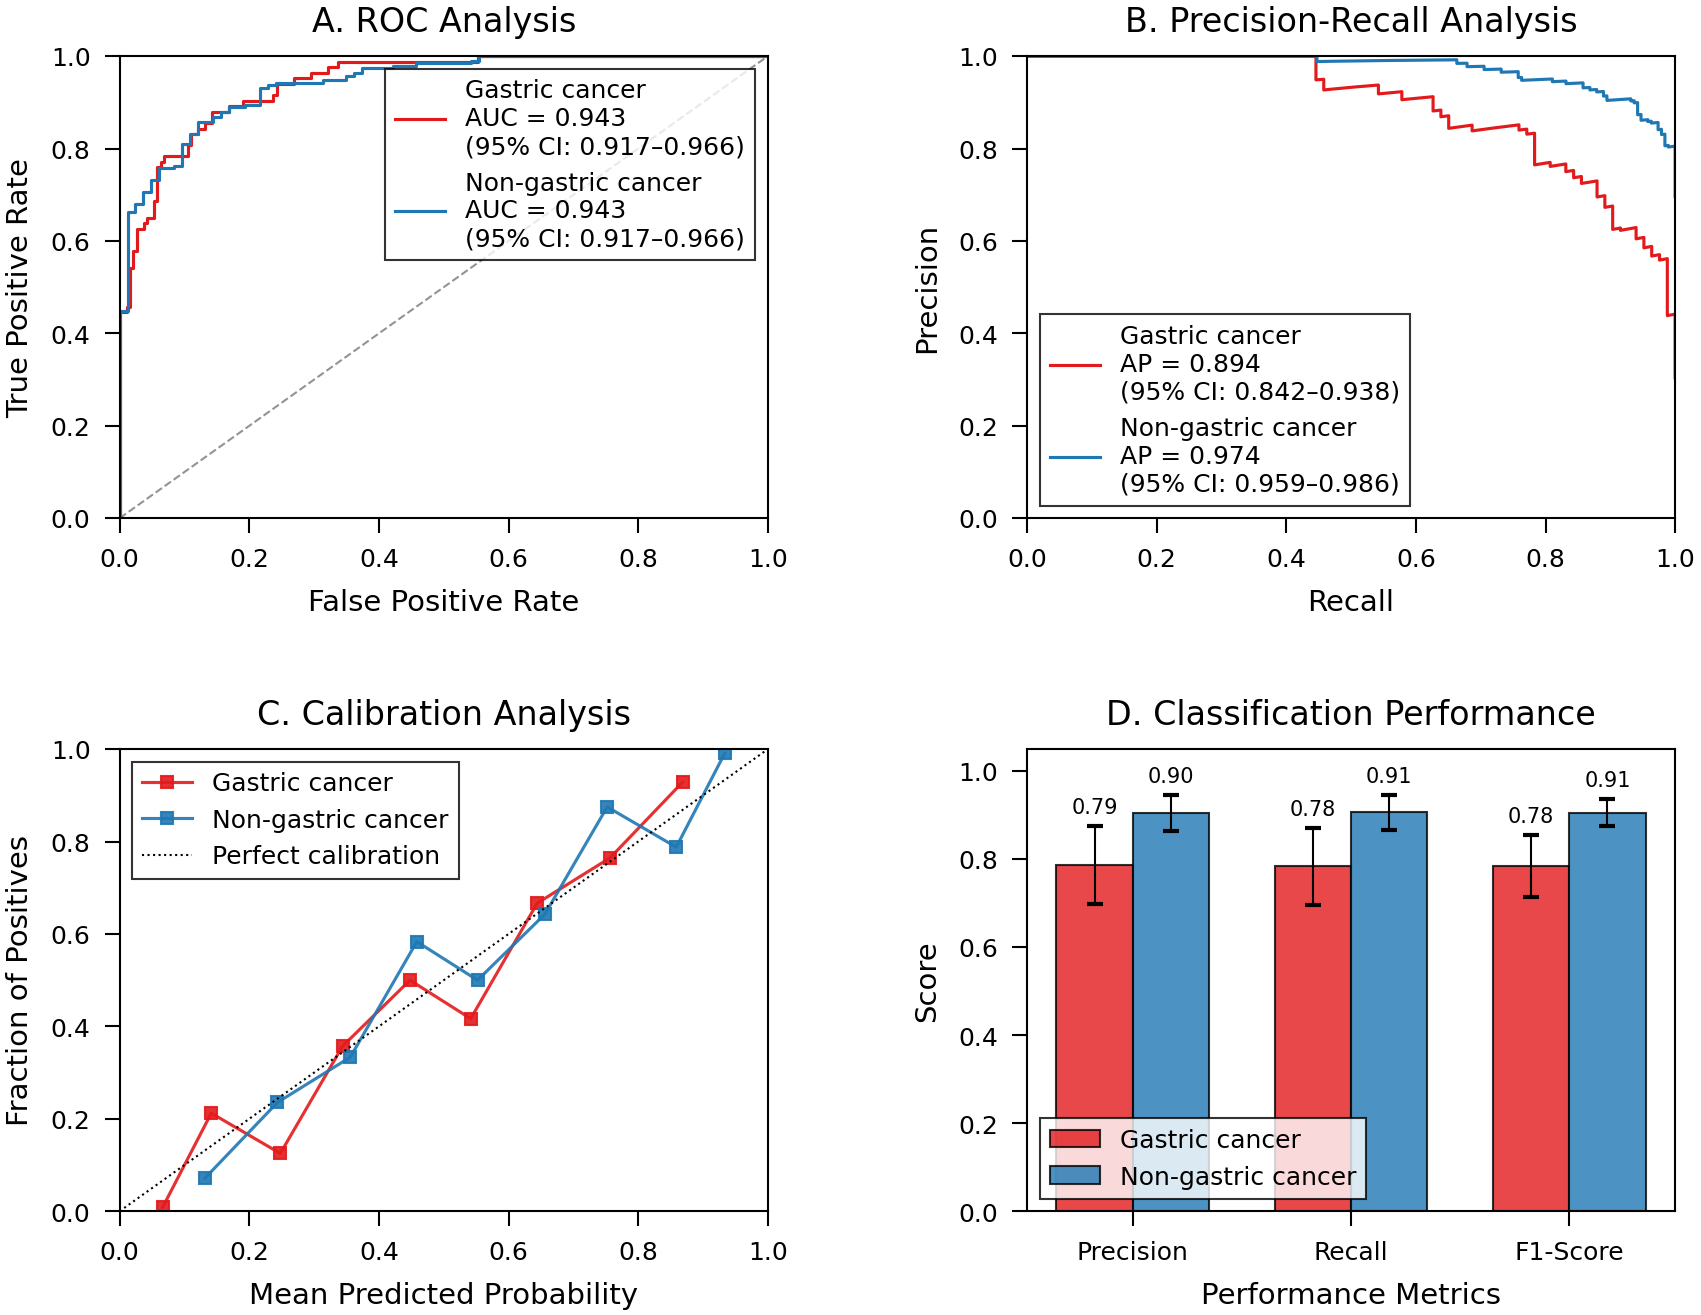

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, roc_curve, auc, 
                           precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, accuracy_score,
                           confusion_matrix)
from sklearn.calibration import calibration_curve

def determine_label_mapping(label_encoder):
    """
    Determine which class corresponds to which numeric label.
    
    Returns:
    - dict: mapping of {class_name: numeric_label}
    """
    classes = label_encoder.classes_
    mapping = {}
    for i, class_name in enumerate(classes):
        mapping[class_name] = i
    
    return mapping

def get_positive_class_info(label_encoder, positive_class_name="Gastric cancer"):
    """
    Get information about the positive class encoding.
    
    Parameters:
    - label_encoder: fitted LabelEncoder
    - positive_class_name: name of the positive class
    
    Returns:
    - dict with positive class info
    """
    mapping = determine_label_mapping(label_encoder)
    
    return {
        'positive_class_name': positive_class_name,
        'positive_class_label': mapping.get(positive_class_name, None),
        'negative_class_name': [k for k in mapping.keys() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'negative_class_label': [v for k, v in mapping.items() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'full_mapping': mapping
    }

def bootstrap_metric(y_true, y_pred, y_proba, metric_func, n_bootstrap=1000, confidence_level=0.95, **kwargs):
    """Bootstrap confidence intervals for metrics."""
    np.random.seed(26)
    n_size = len(y_true)
    bootstrap_scores = []
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n_size, n_size, replace=True)
        
        if y_proba is not None:
            score = metric_func(y_true[indices], y_proba[indices], **kwargs)
        else:
            score = metric_func(y_true[indices], y_pred[indices], **kwargs)
        
        bootstrap_scores.append(score)
    
    bootstrap_scores = np.array(bootstrap_scores)
    
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_scores, (alpha/2) * 100)
    ci_upper = np.percentile(bootstrap_scores, (1 - alpha/2) * 100)
    
    return {
        'mean': np.mean(bootstrap_scores),
        'std': np.std(bootstrap_scores),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'scores': bootstrap_scores
    }

def evaluate_and_plot(model, X_test, y_test, label_encoder, save_prefix, save_path):
    """
    ROBUST evaluation and plotting of the model with confidence intervals.
    
    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - label_encoder: Label encoder used to encode the labels.
    - save_prefix: Prefix for saving the output files.
    - save_path: Path to save the evaluation results and figures.
    """
    
    # Create directories if they don't exist
    os.makedirs(save_path + "/figures", exist_ok=True)
    
    # Get label mapping information
    positive_class_info = get_positive_class_info(label_encoder, "Gastric cancer")
    print(f"Label mapping detected: {positive_class_info['full_mapping']}")
    print(f"Positive class 'Gastric cancer' encoded as: {positive_class_info['positive_class_label']}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Original labels for reporting
    y_test_orig = label_encoder.inverse_transform(y_test)
    y_pred_orig = label_encoder.inverse_transform(y_pred)
    
    # Basic classification report
    report_dict = classification_report(y_test_orig, y_pred_orig, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(
        save_path + f"{save_prefix}_classification_report.csv", index=True
    )
    
    # Get class labels and probabilities
    pos_class_label = positive_class_info['positive_class_label']
    neg_class_label = positive_class_info['negative_class_label']
    y_proba_positive = y_proba[:, pos_class_label]
    y_proba_negative = y_proba[:, neg_class_label]
    
    # Calculate AUC with CI for both classes
    def auc_score_pos(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_class_label)
        return auc(fpr, tpr)
    
    def auc_score_neg(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=neg_class_label)
        return auc(fpr, tpr)
    
    auc_results_pos = bootstrap_metric(y_test, None, y_proba_positive, auc_score_pos)
    auc_results_neg = bootstrap_metric(y_test, None, y_proba_negative, auc_score_neg)
    
    # Calculate AP with CI for both classes  
    def ap_score_pos(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=pos_class_label)
    
    def ap_score_neg(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=neg_class_label)
    
    ap_results_pos = bootstrap_metric(y_test, None, y_proba_positive, ap_score_pos)
    ap_results_neg = bootstrap_metric(y_test, None, y_proba_negative, ap_score_neg)
    
    # Calculate classification metrics with CI for both classes
    prec_results_pos = bootstrap_metric(y_test, y_pred, None, precision_score, 
                                      pos_label=pos_class_label, average='binary')
    rec_results_pos = bootstrap_metric(y_test, y_pred, None, recall_score, 
                                     pos_label=pos_class_label, average='binary')
    f1_results_pos = bootstrap_metric(y_test, y_pred, None, f1_score, 
                                    pos_label=pos_class_label, average='binary')
    
    prec_results_neg = bootstrap_metric(y_test, y_pred, None, precision_score, 
                                      pos_label=neg_class_label, average='binary')
    rec_results_neg = bootstrap_metric(y_test, y_pred, None, recall_score, 
                                     pos_label=neg_class_label, average='binary')
    f1_results_neg = bootstrap_metric(y_test, y_pred, None, f1_score, 
                                    pos_label=neg_class_label, average='binary')
    
    # Store all results for plotting
    classification_results = {
        positive_class_info['positive_class_name']: {
            'Precision': prec_results_pos,
            'Recall': rec_results_pos,
            'F1-Score': f1_results_pos
        },
        positive_class_info['negative_class_name']: {
            'Precision': prec_results_neg,
            'Recall': rec_results_neg,
            'F1-Score': f1_results_neg
        }
    }
    
    # Create enhanced plots with confidence intervals
    create_enhanced_plots(y_test, y_proba, save_path, save_prefix, positive_class_info, 
                         auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg,
                         classification_results)

def create_enhanced_plots(y_test, y_proba, save_path, save_prefix, positive_class_info,
                         auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg,
                         classification_results):
    """Create publication-quality plots with confidence intervals."""
    
    # Publication standards
    plt.rcParams.update({           
        'font.size': 7,                   
        'axes.titlesize': 8,              
        'axes.labelsize': 7,              
        'xtick.labelsize': 6,             
        'ytick.labelsize': 6,             
        'legend.fontsize': 6,             
        'axes.linewidth': 0.5,            
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'lines.linewidth': 0.75,          
        'patch.linewidth': 0.5,           
        'figure.dpi': 300,                
        'savefig.dpi': 300,               
        'savefig.bbox': 'tight',          
        'savefig.pad_inches': 0.02        
    })
    
    # Figure dimensions
    fig_width = 6.69  # 170mm in inches
    fig_height = 5.0   # Allows room for legend, stays under 225mm limit
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(fig_width, fig_height))
    
    # Increase spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Plot 1: ROC Curve with CI
    fpr_pos, tpr_pos, _ = roc_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    fpr_neg, tpr_neg, _ = roc_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax1.plot(fpr_pos, tpr_pos, color='#E31A1C', linewidth=0.75,
            label=f"{pos_name}\nAUC = {auc_results_pos['mean']:.3f}\n(95% CI: {auc_results_pos['ci_lower']:.3f}–{auc_results_pos['ci_upper']:.3f})")
    ax1.plot(fpr_neg, tpr_neg, color='#1F78B4', linewidth=0.75,
            label=f"{neg_name}\nAUC = {auc_results_neg['mean']:.3f}\n(95% CI: {auc_results_neg['ci_lower']:.3f}–{auc_results_neg['ci_upper']:.3f})")
    ax1.plot([0, 1], [0, 1], linestyle='--', color='#666666', alpha=0.7, linewidth=0.5)
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate") 
    ax1.set_title("A. ROC Analysis")
    ax1.legend(frameon=True, fancybox=False, edgecolor='black')
    # Remove grid lines
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Plot 2: PR Curve with CI
    precision_pos, recall_pos, _ = precision_recall_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    precision_neg, recall_neg, _ = precision_recall_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax2.plot(recall_pos, precision_pos, color='#E31A1C', linewidth=0.75,
            label=f"{pos_name}\nAP = {ap_results_pos['mean']:.3f}\n(95% CI: {ap_results_pos['ci_lower']:.3f}–{ap_results_pos['ci_upper']:.3f})")
    ax2.plot(recall_neg, precision_neg, color='#1F78B4', linewidth=0.75,
            label=f"{neg_name}\nAP = {ap_results_neg['mean']:.3f}\n(95% CI: {ap_results_neg['ci_lower']:.3f}–{ap_results_neg['ci_upper']:.3f})")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("B. Precision-Recall Analysis")
    ax2.legend(frameon=True, fancybox=False, edgecolor='black')
    # Remove grid lines
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    # Plot 3: Calibration Plot
    y_true_pos = (y_test == pos_label).astype(int)
    y_true_neg = (y_test == neg_label).astype(int)
    fraction_pos, mean_pred_pos = calibration_curve(y_true_pos, y_proba[:, pos_label], n_bins=10)
    fraction_neg, mean_pred_neg = calibration_curve(y_true_neg, y_proba[:, neg_label], n_bins=10)
    
    ax3.plot(mean_pred_pos, fraction_pos, "s-", label=f"{pos_name}", alpha=0.9, 
            color='#E31A1C', markersize=3, linewidth=0.75, markeredgewidth=0.5)
    ax3.plot(mean_pred_neg, fraction_neg, "s-", label=f"{neg_name}", alpha=0.9, 
            color='#1F78B4', markersize=3, linewidth=0.75, markeredgewidth=0.5)
    ax3.plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=0.5)
    ax3.set_xlabel("Mean Predicted Probability")
    ax3.set_ylabel("Fraction of Positives")
    ax3.set_title("C. Calibration Analysis")
    ax3.legend(frameon=True, fancybox=False, edgecolor='black')
    # Remove grid lines
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    
    # Plot 4: Classification Metrics Bar Plot with CI
    metrics = ['Precision', 'Recall', 'F1-Score']
    class_names = list(classification_results.keys())
    
    # Extract means and error bars (half of CI width)
    pos_means = [classification_results[class_names[0]][m]['mean'] for m in metrics]
    pos_errors = [(classification_results[class_names[0]][m]['ci_upper'] - 
                   classification_results[class_names[0]][m]['ci_lower'])/2 for m in metrics]
    
    neg_means = [classification_results[class_names[1]][m]['mean'] for m in metrics]
    neg_errors = [(classification_results[class_names[1]][m]['ci_upper'] - 
                   classification_results[class_names[1]][m]['ci_lower'])/2 for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, pos_means, width, yerr=pos_errors, 
                    label=class_names[0], capsize=2, alpha=0.8, color='#E31A1C',
                    linewidth=0.5, edgecolor='black', error_kw={'linewidth': 0.5})
    bars2 = ax4.bar(x + width/2, neg_means, width, yerr=neg_errors, 
                    label=class_names[1], capsize=2, alpha=0.8, color='#1F78B4',
                    linewidth=0.5, edgecolor='black', error_kw={'linewidth': 0.5})
    
    # Add value labels on top of bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        ax4.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + pos_errors[i] + 0.02,
                f'{pos_means[i]:.2f}', ha='center', va='bottom', fontsize=5)
        ax4.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + neg_errors[i] + 0.02,
                f'{neg_means[i]:.2f}', ha='center', va='bottom', fontsize=5)
    
    ax4.set_xlabel('Performance Metrics')
    ax4.set_ylabel('Score')
    ax4.set_title('D. Classification Performance')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend(frameon=True, fancybox=False, edgecolor='black')
    # Remove grid lines
    ax4.set_ylim(0, 1.05)  # Slight headroom for labels
    
    # Save in multiple formats
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.png", 
                dpi=300, bbox_inches='tight', pad_inches=0.02, format='png')
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.pdf", 
               bbox_inches='tight', pad_inches=0.02, format='pdf')
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.eps", 
                bbox_inches='tight', pad_inches=0.02, format='eps')
    
    plt.show()
    # plt.close()

# Call the evaluation function with the model, test data, label encoder, and save path
evaluate_and_plot(xgb_calibrated_model, X_test_reduced, y_test_set_encoded, le, 
                  "XGB_evaluation", "../results/2025-08-11_XGB_evaluation")

Label mapping detected: {'Gastric cancer': 0, 'Non-gastric cancer': 1}
Positive class 'Gastric cancer' encoded as: 0


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

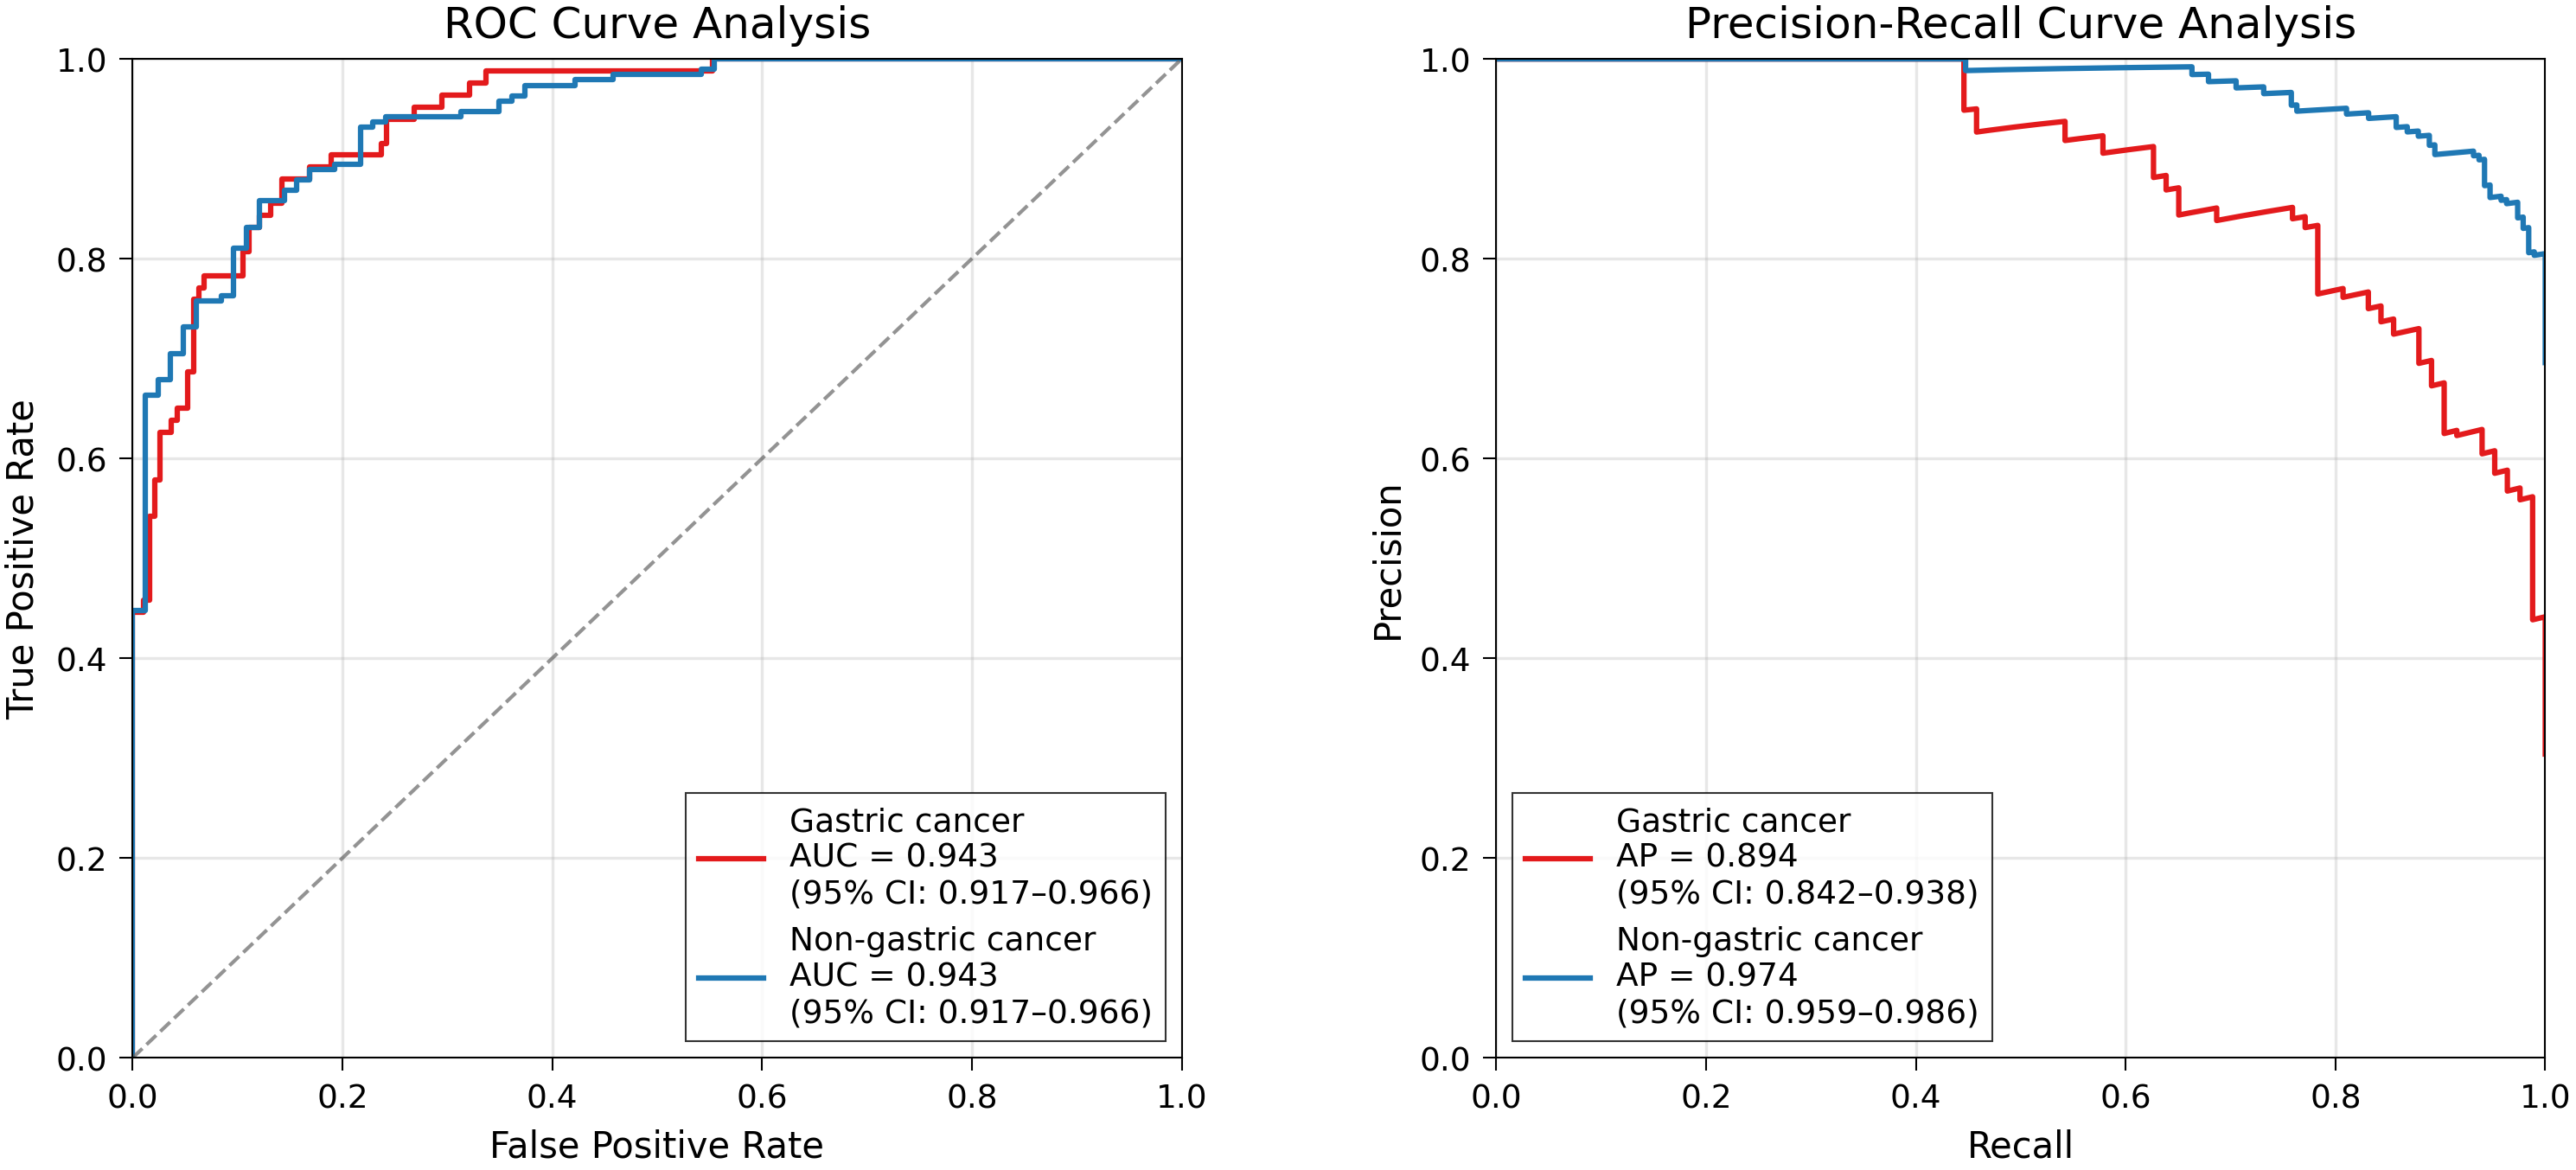

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

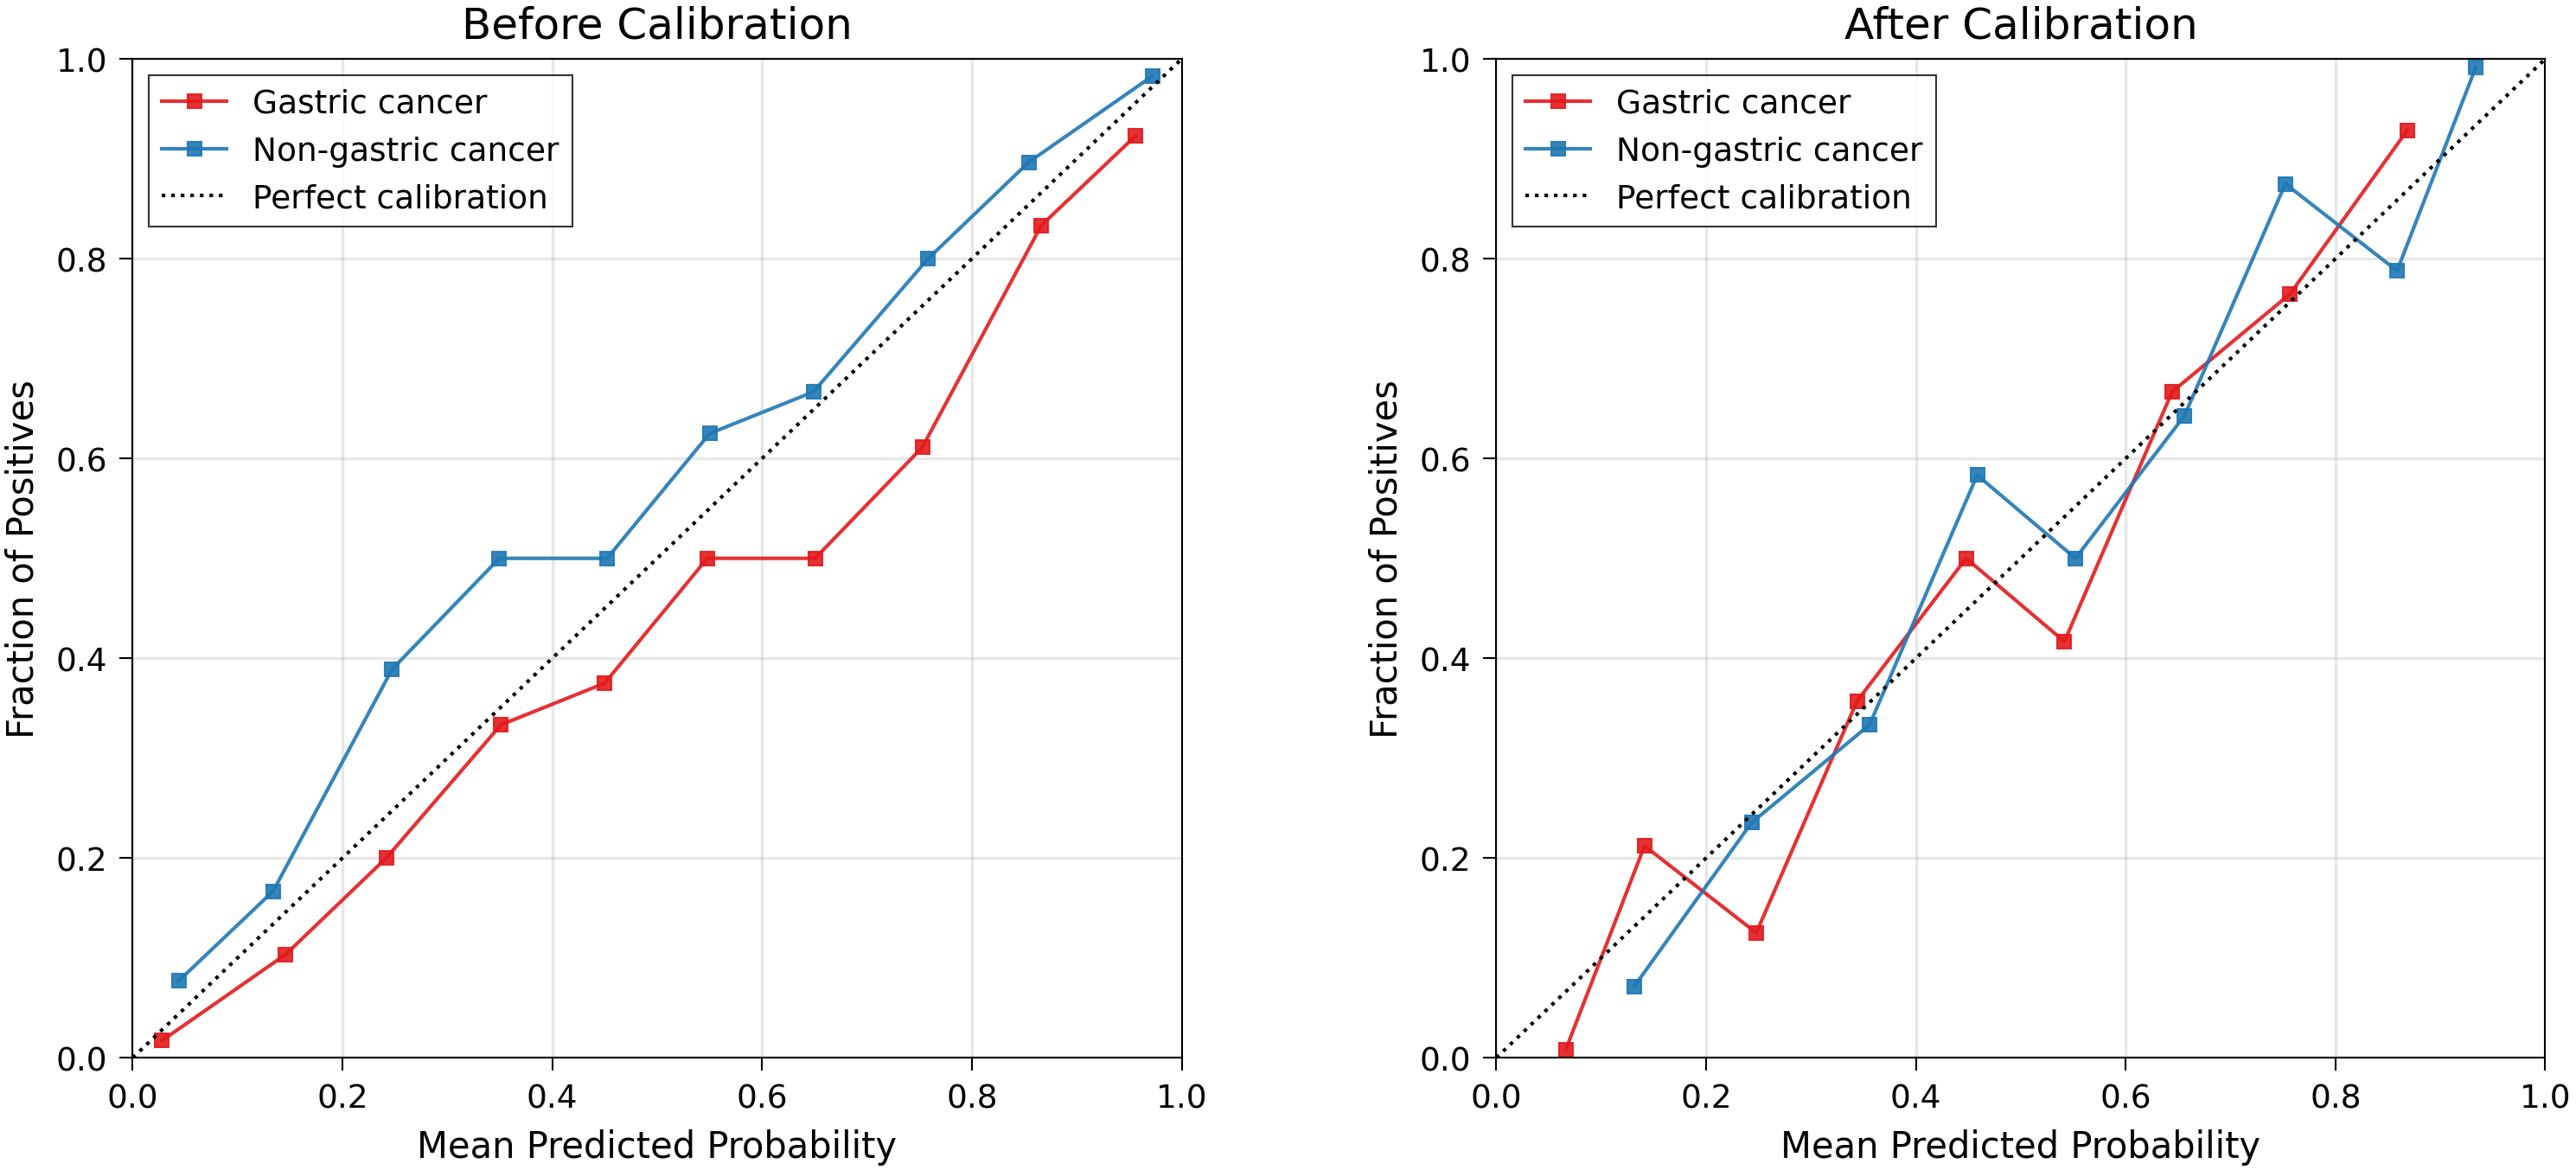

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, roc_curve, auc, 
                           precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, accuracy_score,
                           confusion_matrix)
from sklearn.calibration import calibration_curve

def determine_label_mapping(label_encoder):
    """
    Determine which class corresponds to which numeric label.
    
    Returns:
    - dict: mapping of {class_name: numeric_label}
    """
    classes = label_encoder.classes_
    mapping = {}
    for i, class_name in enumerate(classes):
        mapping[class_name] = i
    
    return mapping

def get_positive_class_info(label_encoder, positive_class_name="Gastric cancer"):
    """
    Get information about the positive class encoding.
    
    Parameters:
    - label_encoder: fitted LabelEncoder
    - positive_class_name: name of the positive class
    
    Returns:
    - dict with positive class info
    """
    mapping = determine_label_mapping(label_encoder)
    
    return {
        'positive_class_name': positive_class_name,
        'positive_class_label': mapping.get(positive_class_name, None),
        'negative_class_name': [k for k in mapping.keys() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'negative_class_label': [v for k, v in mapping.items() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'full_mapping': mapping
    }

def bootstrap_metric(y_true, y_pred, y_proba, metric_func, n_bootstrap=1000, confidence_level=0.95, **kwargs):
    """Bootstrap confidence intervals for metrics."""
    np.random.seed(26)
    n_size = len(y_true)
    bootstrap_scores = []
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n_size, n_size, replace=True)
        
        if y_proba is not None:
            score = metric_func(y_true[indices], y_proba[indices], **kwargs)
        else:
            score = metric_func(y_true[indices], y_pred[indices], **kwargs)
        
        bootstrap_scores.append(score)
    
    bootstrap_scores = np.array(bootstrap_scores)
    
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_scores, (alpha/2) * 100)
    ci_upper = np.percentile(bootstrap_scores, (1 - alpha/2) * 100)
    
    return {
        'mean': np.mean(bootstrap_scores),
        'std': np.std(bootstrap_scores),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'scores': bootstrap_scores
    }

def evaluate_and_plot(model, X_test, y_test, label_encoder, save_prefix, save_path, 
                     uncalibrated_model=None):
    """
    ROBUST evaluation and plotting of the model with confidence intervals.
    
    Parameters:
    - model: Trained calibrated model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - label_encoder: Label encoder used to encode the labels.
    - save_prefix: Prefix for saving the output files.
    - save_path: Path to save the evaluation results and figures.
    - uncalibrated_model: Original uncalibrated model (for before/after comparison)
    """
    
    # Create directories if they don't exist
    os.makedirs(save_path + "/figures", exist_ok=True)
    
    # Get label mapping information
    positive_class_info = get_positive_class_info(label_encoder, "Gastric cancer")
    print(f"Label mapping detected: {positive_class_info['full_mapping']}")
    print(f"Positive class 'Gastric cancer' encoded as: {positive_class_info['positive_class_label']}")
    
    # Predictions from calibrated model
    y_pred = model.predict(X_test)
    y_proba_calibrated = model.predict_proba(X_test)
    
    # Predictions from uncalibrated model (if provided)
    y_proba_uncalibrated = None
    if uncalibrated_model is not None:
        y_proba_uncalibrated = uncalibrated_model.predict_proba(X_test)
    
    # Original labels for reporting
    y_test_orig = label_encoder.inverse_transform(y_test)
    y_pred_orig = label_encoder.inverse_transform(y_pred)
    
    # Basic classification report
    report_dict = classification_report(y_test_orig, y_pred_orig, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(
        save_path + f"{save_prefix}_classification_report.csv", index=True
    )
    
    # Get class labels and probabilities
    pos_class_label = positive_class_info['positive_class_label']
    neg_class_label = positive_class_info['negative_class_label']
    y_proba_positive = y_proba_calibrated[:, pos_class_label]
    y_proba_negative = y_proba_calibrated[:, neg_class_label]
    
    # Calculate AUC with CI for both classes
    def auc_score_pos(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_class_label)
        return auc(fpr, tpr)
    
    def auc_score_neg(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=neg_class_label)
        return auc(fpr, tpr)
    
    auc_results_pos = bootstrap_metric(y_test, None, y_proba_positive, auc_score_pos)
    auc_results_neg = bootstrap_metric(y_test, None, y_proba_negative, auc_score_neg)
    
    # Calculate AP with CI for both classes  
    def ap_score_pos(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=pos_class_label)
    
    def ap_score_neg(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=neg_class_label)
    
    ap_results_pos = bootstrap_metric(y_test, None, y_proba_positive, ap_score_pos)
    ap_results_neg = bootstrap_metric(y_test, None, y_proba_negative, ap_score_neg)
    
    # Create separate plots
    create_roc_pr_plots(y_test, y_proba_calibrated, save_path, save_prefix, positive_class_info, 
                       auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg)
    
    create_calibration_plots(y_test, y_proba_calibrated, y_proba_uncalibrated, 
                           save_path, save_prefix, positive_class_info)

def create_roc_pr_plots(y_test, y_proba, save_path, save_prefix, positive_class_info,
                       auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg):
    """Create ROC and PR curves in a single figure."""
    
    # Publication standards
    plt.rcParams.update({           
        'font.size': 10,                   
        'axes.titlesize': 12,              
        'axes.labelsize': 10,              
        'xtick.labelsize': 9,             
        'ytick.labelsize': 9,             
        'legend.fontsize': 9,             
        'axes.linewidth': 0.5,            
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'lines.linewidth': 1.0,          
        'patch.linewidth': 0.5,           
        'figure.dpi': 300,                
        'savefig.dpi': 300,               
        'savefig.bbox': 'tight',          
        'savefig.pad_inches': 0.02        
    })
    
    # Figure dimensions
    fig_width = 12
    fig_height = 5
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height))
    
    # Increase spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Plot 1: ROC Curve with CI
    fpr_pos, tpr_pos, _ = roc_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    fpr_neg, tpr_neg, _ = roc_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax1.plot(fpr_pos, tpr_pos, color='#E31A1C', linewidth=1.5,
            label=f"{pos_name}\nAUC = {auc_results_pos['mean']:.3f}\n(95% CI: {auc_results_pos['ci_lower']:.3f}–{auc_results_pos['ci_upper']:.3f})")
    ax1.plot(fpr_neg, tpr_neg, color='#1F78B4', linewidth=1.5,
            label=f"{neg_name}\nAUC = {auc_results_neg['mean']:.3f}\n(95% CI: {auc_results_neg['ci_lower']:.3f}–{auc_results_neg['ci_upper']:.3f})")
    ax1.plot([0, 1], [0, 1], linestyle='--', color='#666666', alpha=0.7, linewidth=1.0)
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate") 
    ax1.set_title("ROC Curve Analysis")
    ax1.legend(frameon=True, fancybox=False, edgecolor='black')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Plot 2: PR Curve with CI
    precision_pos, recall_pos, _ = precision_recall_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    precision_neg, recall_neg, _ = precision_recall_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax2.plot(recall_pos, precision_pos, color='#E31A1C', linewidth=1.5,
            label=f"{pos_name}\nAP = {ap_results_pos['mean']:.3f}\n(95% CI: {ap_results_pos['ci_lower']:.3f}–{ap_results_pos['ci_upper']:.3f})")
    ax2.plot(recall_neg, precision_neg, color='#1F78B4', linewidth=1.5,
            label=f"{neg_name}\nAP = {ap_results_neg['mean']:.3f}\n(95% CI: {ap_results_neg['ci_lower']:.3f}–{ap_results_neg['ci_upper']:.3f})")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision-Recall Curve Analysis")
    ax2.legend(frameon=True, fancybox=False, edgecolor='black')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    # Save in multiple formats
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.png", 
                dpi=300, bbox_inches='tight', pad_inches=0.02, format='png')
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.pdf", 
               bbox_inches='tight', pad_inches=0.02, format='pdf')
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.eps", 
                bbox_inches='tight', pad_inches=0.02, format='eps')
    
    plt.show()

def create_calibration_plots(y_test, y_proba_calibrated, y_proba_uncalibrated, 
                           save_path, save_prefix, positive_class_info):
    """Create before and after calibration plots."""
    
    # Publication standards
    plt.rcParams.update({           
        'font.size': 10,                   
        'axes.titlesize': 12,              
        'axes.labelsize': 10,              
        'xtick.labelsize': 9,             
        'ytick.labelsize': 9,             
        'legend.fontsize': 9,             
        'axes.linewidth': 0.5,            
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'lines.linewidth': 1.0,          
        'patch.linewidth': 0.5,           
        'figure.dpi': 300,                
        'savefig.dpi': 300,               
        'savefig.bbox': 'tight',          
        'savefig.pad_inches': 0.02        
    })
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Determine number of subplots based on available data
    n_plots = 2 if y_proba_uncalibrated is not None else 1
    fig_width = 12 if n_plots == 2 else 6
    fig_height = 5
    
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_width, fig_height))
    if n_plots == 1:
        axes = [axes]
    
    # Increase spacing between subplots if there are multiple
    if n_plots == 2:
        plt.subplots_adjust(wspace=0.3)
    
    # Plot calibration curves
    y_true_pos = (y_test == pos_label).astype(int)
    y_true_neg = (y_test == neg_label).astype(int)
    
    plot_idx = 0
    
    # Before calibration plot (if uncalibrated model provided)
    if y_proba_uncalibrated is not None:
        fraction_pos_uncal, mean_pred_pos_uncal = calibration_curve(y_true_pos, y_proba_uncalibrated[:, pos_label], n_bins=10)
        fraction_neg_uncal, mean_pred_neg_uncal = calibration_curve(y_true_neg, y_proba_uncalibrated[:, neg_label], n_bins=10)
        
        axes[plot_idx].plot(mean_pred_pos_uncal, fraction_pos_uncal, "s-", label=f"{pos_name}", alpha=0.9, 
                color='#E31A1C', markersize=4, linewidth=1.0, markeredgewidth=0.5)
        axes[plot_idx].plot(mean_pred_neg_uncal, fraction_neg_uncal, "s-", label=f"{neg_name}", alpha=0.9, 
                color='#1F78B4', markersize=4, linewidth=1.0, markeredgewidth=0.5)
        axes[plot_idx].plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=1.0)
        axes[plot_idx].set_xlabel("Mean Predicted Probability")
        axes[plot_idx].set_ylabel("Fraction of Positives")
        axes[plot_idx].set_title("Before Calibration")
        axes[plot_idx].legend(frameon=True, fancybox=False, edgecolor='black')
        axes[plot_idx].grid(True, alpha=0.3)
        axes[plot_idx].set_xlim(0, 1)
        axes[plot_idx].set_ylim(0, 1)
        plot_idx += 1
    
    # After calibration plot
    fraction_pos_cal, mean_pred_pos_cal = calibration_curve(y_true_pos, y_proba_calibrated[:, pos_label], n_bins=10)
    fraction_neg_cal, mean_pred_neg_cal = calibration_curve(y_true_neg, y_proba_calibrated[:, neg_label], n_bins=10)
    
    axes[plot_idx].plot(mean_pred_pos_cal, fraction_pos_cal, "s-", label=f"{pos_name}", alpha=0.9, 
            color='#E31A1C', markersize=4, linewidth=1.0, markeredgewidth=0.5)
    axes[plot_idx].plot(mean_pred_neg_cal, fraction_neg_cal, "s-", label=f"{neg_name}", alpha=0.9, 
            color='#1F78B4', markersize=4, linewidth=1.0, markeredgewidth=0.5)
    axes[plot_idx].plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=1.0)
    axes[plot_idx].set_xlabel("Mean Predicted Probability")
    axes[plot_idx].set_ylabel("Fraction of Positives")
    axes[plot_idx].set_title("After Calibration" if y_proba_uncalibrated is not None else "Calibration Analysis")
    axes[plot_idx].legend(frameon=True, fancybox=False, edgecolor='black')
    axes[plot_idx].grid(True, alpha=0.3)
    axes[plot_idx].set_xlim(0, 1)
    axes[plot_idx].set_ylim(0, 1)
    
    # Save in multiple formats
    suffix = "_calibration_comparison" if y_proba_uncalibrated is not None else "_calibration"
    fig.savefig(f"{save_path}/figures/{save_prefix}{suffix}.png", 
                dpi=300, bbox_inches='tight', pad_inches=0.02, format='png')
    fig.savefig(f"{save_path}/figures/{save_prefix}{suffix}.pdf", 
               bbox_inches='tight', pad_inches=0.02, format='pdf')
    fig.savefig(f"{save_path}/figures/{save_prefix}{suffix}.eps", 
                bbox_inches='tight', pad_inches=0.02, format='eps')
    
    plt.show()

# Call the evaluation function with the model, test data, label encoder, and save path
# If you have the uncalibrated model, pass it as the last parameter
evaluate_and_plot(xgb_calibrated_model, X_test_reduced, y_test_set_encoded, le, 
                  "XGB_evaluation", "../results/2025-08-11_XGB_evaluation",
                  uncalibrated_model=xgb_bayes_search)  # Add your uncalibrated model here

Label mapping detected: {'Gastric cancer': 0, 'Non-gastric cancer': 1}
Positive class 'Gastric cancer' encoded as: 0


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

=== BRIER SCORE ANALYSIS ===
After Calibration:
  Gastric cancer: 0.0908
  Non-gastric cancer: 0.0908
  Average: 0.0908

Before Calibration:
  Gastric cancer: 0.0959
  Non-gastric cancer: 0.0959
  Average: 0.0959

Improvement (positive = better):
  Gastric cancer: +0.0051
  Non-gastric cancer: +0.0051
  Average: +0.0051
✓ Calibration IMPROVED overall

=== ADDITIONAL CALIBRATION METRICS (Gastric cancer) ===
Expected Calibration Error (After): 0.0595
Calibration Slope (After): 1.3373 (ideal = 1.0)
Calibration Intercept (After): -0.0255 (ideal = 0.0)
Expected Calibration Error (Before): 0.0381
ECE Improvement: -0.0214
Calibration Slope (Before): 0.9847
Calibration Intercept (Before): -0.4130

Results saved to: ../results/2025-08-11_XGB_evaluation/XGB_evaluation_brier_scores.csv


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

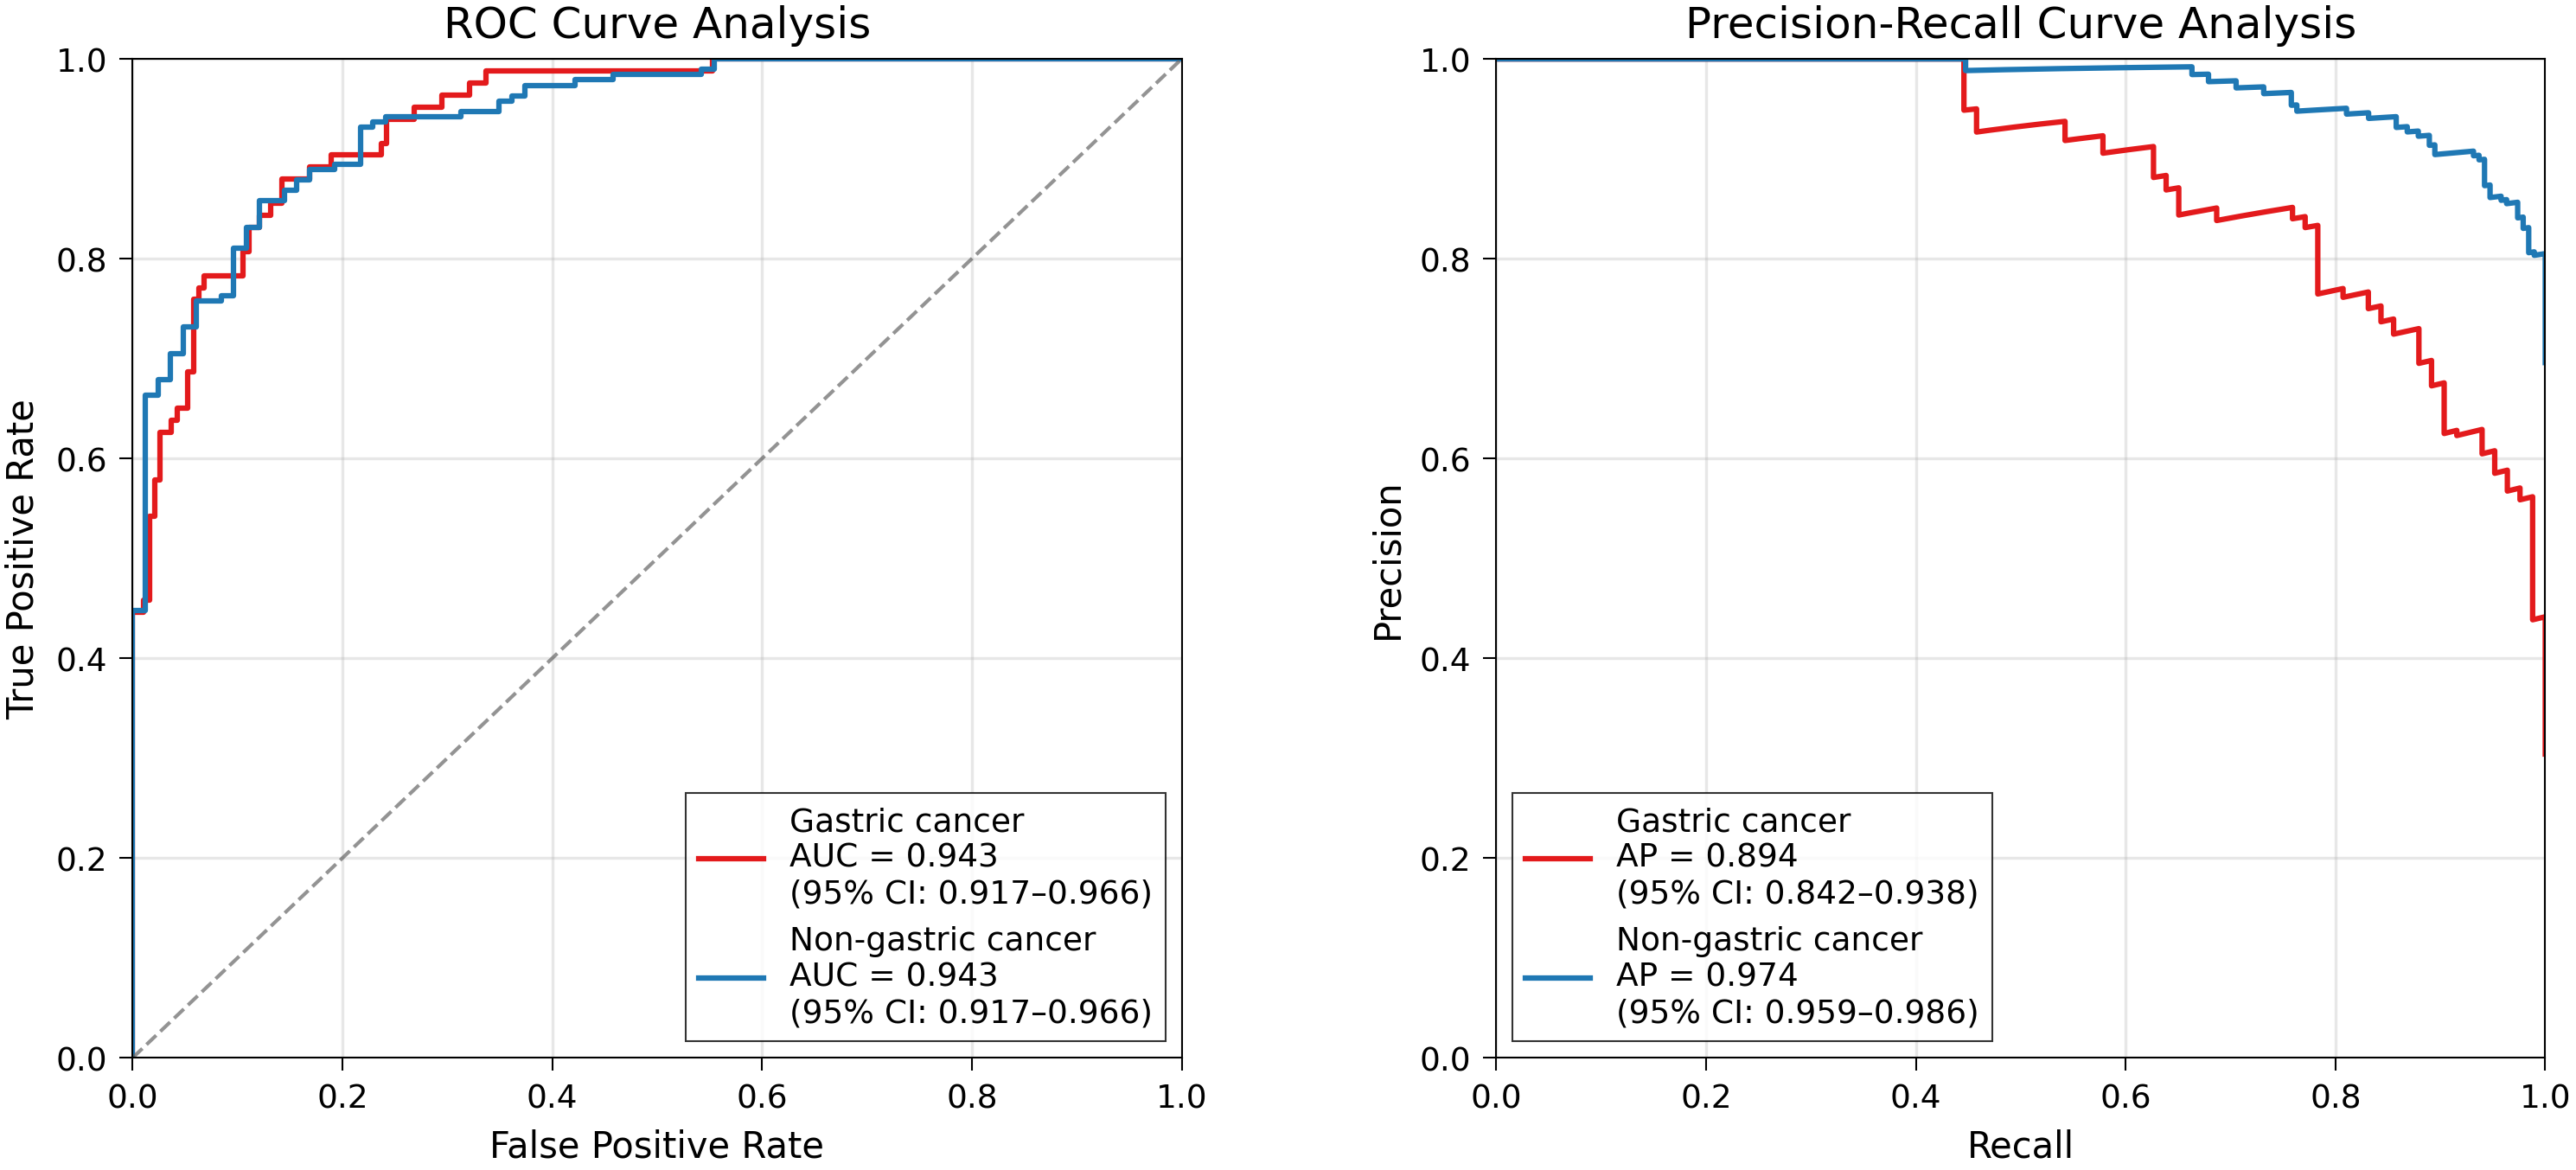

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

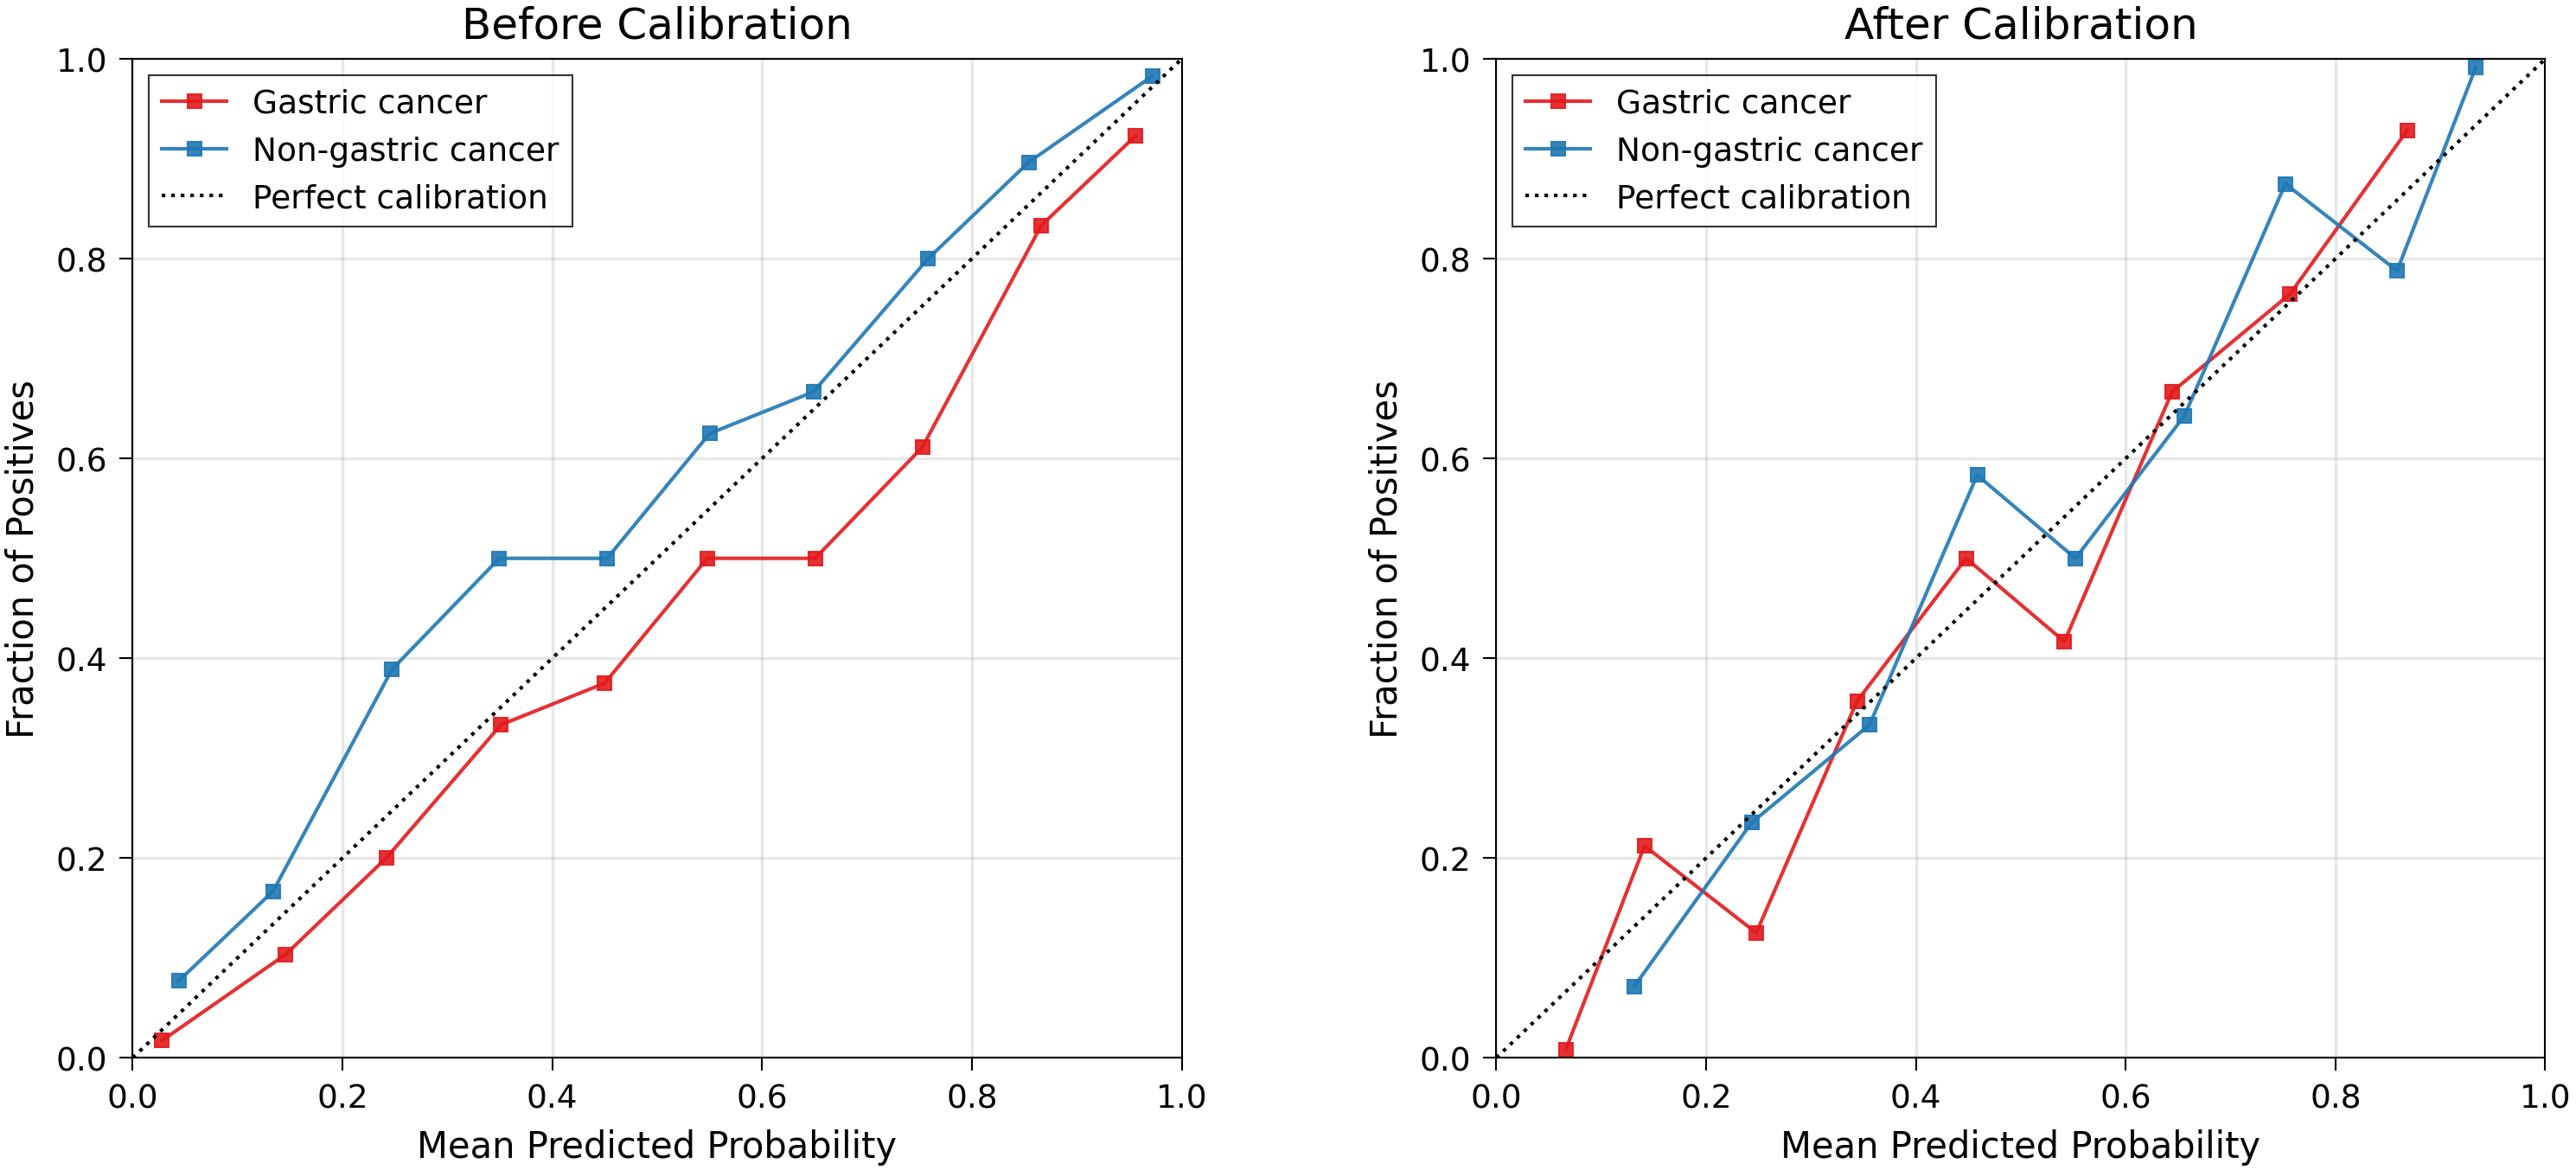

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, roc_curve, auc, 
                           precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, accuracy_score,
                           confusion_matrix, brier_score_loss)
from sklearn.calibration import calibration_curve

def determine_label_mapping(label_encoder):
    """
    Determine which class corresponds to which numeric label.
    
    Returns:
    - dict: mapping of {class_name: numeric_label}
    """
    classes = label_encoder.classes_
    mapping = {}
    for i, class_name in enumerate(classes):
        mapping[class_name] = i
    
    return mapping

def get_positive_class_info(label_encoder, positive_class_name="Gastric cancer"):
    """
    Get information about the positive class encoding.
    
    Parameters:
    - label_encoder: fitted LabelEncoder
    - positive_class_name: name of the positive class
    
    Returns:
    - dict with positive class info
    """
    mapping = determine_label_mapping(label_encoder)
    
    return {
        'positive_class_name': positive_class_name,
        'positive_class_label': mapping.get(positive_class_name, None),
        'negative_class_name': [k for k in mapping.keys() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'negative_class_label': [v for k, v in mapping.items() if k != positive_class_name][0] if len(mapping) == 2 else None,
        'full_mapping': mapping
    }

def calculate_brier_scores(y_test, y_proba_calibrated, y_proba_uncalibrated, 
                          positive_class_info, save_path, save_prefix):
    """Calculate and save Brier scores for calibration assessment."""
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Convert to binary format for Brier score calculation
    y_true_pos = (y_test == pos_label).astype(int)
    y_true_neg = (y_test == neg_label).astype(int)
    
    # Calculate Brier scores for calibrated model
    brier_pos_cal = brier_score_loss(y_true_pos, y_proba_calibrated[:, pos_label])
    brier_neg_cal = brier_score_loss(y_true_neg, y_proba_calibrated[:, neg_label])
    
    print("=== BRIER SCORE ANALYSIS ===")
    print(f"After Calibration:")
    print(f"  {pos_name}: {brier_pos_cal:.4f}")
    print(f"  {neg_name}: {brier_neg_cal:.4f}")
    print(f"  Average: {(brier_pos_cal + brier_neg_cal) / 2:.4f}")
    
    results = {
        'metric': 'Brier Score',
        'pos_class': pos_name,
        'neg_class': neg_name,
        'after_calibration': {
            pos_name: brier_pos_cal,
            neg_name: brier_neg_cal,
            'average': (brier_pos_cal + brier_neg_cal) / 2
        }
    }
    
    # Calculate for uncalibrated model if available
    if y_proba_uncalibrated is not None:
        brier_pos_uncal = brier_score_loss(y_true_pos, y_proba_uncalibrated[:, pos_label])
        brier_neg_uncal = brier_score_loss(y_true_neg, y_proba_uncalibrated[:, neg_label])
        
        print(f"\nBefore Calibration:")
        print(f"  {pos_name}: {brier_pos_uncal:.4f}")
        print(f"  {neg_name}: {brier_neg_uncal:.4f}")
        print(f"  Average: {(brier_pos_uncal + brier_neg_uncal) / 2:.4f}")
        
        # Calculate improvements
        improvement_pos = brier_pos_uncal - brier_pos_cal
        improvement_neg = brier_neg_uncal - brier_neg_cal
        improvement_avg = (improvement_pos + improvement_neg) / 2
        
        print(f"\nImprovement (positive = better):")
        print(f"  {pos_name}: {improvement_pos:+.4f}")
        print(f"  {neg_name}: {improvement_neg:+.4f}")
        print(f"  Average: {improvement_avg:+.4f}")
        
        if improvement_avg > 0:
            print(f"✓ Calibration IMPROVED overall")
        else:
            print(f"✗ Calibration WORSENED overall")
        
        results['before_calibration'] = {
            pos_name: brier_pos_uncal,
            neg_name: brier_neg_uncal,
            'average': (brier_pos_uncal + brier_neg_uncal) / 2
        }
        results['improvement'] = {
            pos_name: improvement_pos,
            neg_name: improvement_neg,
            'average': improvement_avg
        }
    
    # Calculate additional calibration metrics
    calculate_additional_calibration_metrics(y_test, y_proba_calibrated, y_proba_uncalibrated,
                                           positive_class_info, results)
    
    # Save results to CSV
    results_df = pd.DataFrame({
        'Metric': ['Brier Score'],
        f'{pos_name}_After': [results['after_calibration'][pos_name]],
        f'{neg_name}_After': [results['after_calibration'][neg_name]],
        'Average_After': [results['after_calibration']['average']],
    })
    
    if y_proba_uncalibrated is not None:
        results_df[f'{pos_name}_Before'] = [results['before_calibration'][pos_name]]
        results_df[f'{neg_name}_Before'] = [results['before_calibration'][neg_name]]
        results_df['Average_Before'] = [results['before_calibration']['average']]
        results_df[f'{pos_name}_Improvement'] = [results['improvement'][pos_name]]
        results_df[f'{neg_name}_Improvement'] = [results['improvement'][neg_name]]
        results_df['Average_Improvement'] = [results['improvement']['average']]
    
    results_df.to_csv(f"{save_path}/{save_prefix}_brier_scores.csv", index=False)
    print(f"\nResults saved to: {save_path}/{save_prefix}_brier_scores.csv")

def calculate_additional_calibration_metrics(y_test, y_proba_calibrated, y_proba_uncalibrated,
                                           positive_class_info, results):
    """Calculate additional calibration metrics beyond Brier score."""
    
    pos_label = positive_class_info['positive_class_label']
    pos_name = positive_class_info['positive_class_name']
    
    # Focus on positive class for additional metrics
    y_true_pos = (y_test == pos_label).astype(int)
    y_prob_pos_cal = y_proba_calibrated[:, pos_label]
    
    print(f"\n=== ADDITIONAL CALIBRATION METRICS ({pos_name}) ===")
    
    # Expected Calibration Error (ECE)
    def expected_calibration_error(y_true, y_prob, n_bins=10):
        """Calculate Expected Calibration Error."""
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
            prop_in_bin = in_bin.mean()
            
            if prop_in_bin > 0:
                accuracy_in_bin = y_true[in_bin].mean()
                avg_confidence_in_bin = y_prob[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        
        return ece
    
    # Calculate ECE for calibrated model
    ece_cal = expected_calibration_error(y_true_pos, y_prob_pos_cal)
    print(f"Expected Calibration Error (After): {ece_cal:.4f}")
    
    # Calculate calibration slope and intercept using logistic regression
    from sklearn.linear_model import LogisticRegression
    
    # Calibration slope and intercept (after calibration)
    log_odds_cal = np.log(y_prob_pos_cal / (1 - y_prob_pos_cal + 1e-15))
    cal_model = LogisticRegression(penalty=None, max_iter=1000)
    cal_model.fit(log_odds_cal.reshape(-1, 1), y_true_pos)
    
    cal_slope_after = cal_model.coef_[0][0]
    cal_intercept_after = cal_model.intercept_[0]
    
    print(f"Calibration Slope (After): {cal_slope_after:.4f} (ideal = 1.0)")
    print(f"Calibration Intercept (After): {cal_intercept_after:.4f} (ideal = 0.0)")
    
    # Calculate for uncalibrated if available
    if y_proba_uncalibrated is not None:
        y_prob_pos_uncal = y_proba_uncalibrated[:, pos_label]
        
        # ECE before calibration
        ece_uncal = expected_calibration_error(y_true_pos, y_prob_pos_uncal)
        print(f"Expected Calibration Error (Before): {ece_uncal:.4f}")
        print(f"ECE Improvement: {ece_uncal - ece_cal:+.4f}")
        
        # Calibration slope and intercept (before calibration)
        log_odds_uncal = np.log(y_prob_pos_uncal / (1 - y_prob_pos_uncal + 1e-15))
        uncal_model = LogisticRegression(penalty=None, max_iter=1000)
        uncal_model.fit(log_odds_uncal.reshape(-1, 1), y_true_pos)
        
        cal_slope_before = uncal_model.coef_[0][0]
        cal_intercept_before = uncal_model.intercept_[0]
        
        print(f"Calibration Slope (Before): {cal_slope_before:.4f}")
        print(f"Calibration Intercept (Before): {cal_intercept_before:.4f}")

def bootstrap_metric(y_true, y_pred, y_proba, metric_func, n_bootstrap=1000, confidence_level=0.95, **kwargs):
    """Bootstrap confidence intervals for metrics."""
    np.random.seed(26)
    n_size = len(y_true)
    bootstrap_scores = []
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n_size, n_size, replace=True)
        
        if y_proba is not None:
            score = metric_func(y_true[indices], y_proba[indices], **kwargs)
        else:
            score = metric_func(y_true[indices], y_pred[indices], **kwargs)
        
        bootstrap_scores.append(score)
    
    bootstrap_scores = np.array(bootstrap_scores)
    
    alpha = 1 - confidence_level
    ci_lower = np.percentile(bootstrap_scores, (alpha/2) * 100)
    ci_upper = np.percentile(bootstrap_scores, (1 - alpha/2) * 100)
    
    return {
        'mean': np.mean(bootstrap_scores),
        'std': np.std(bootstrap_scores),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'scores': bootstrap_scores
    }

def evaluate_and_plot(model, X_test, y_test, label_encoder, save_prefix, save_path, 
                     uncalibrated_model=None):
    """
    ROBUST evaluation and plotting of the model with confidence intervals.
    
    Parameters:
    - model: Trained calibrated model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - label_encoder: Label encoder used to encode the labels.
    - save_prefix: Prefix for saving the output files.
    - save_path: Path to save the evaluation results and figures.
    - uncalibrated_model: Original uncalibrated model (for before/after comparison)
    """
    
    # Create directories if they don't exist
    os.makedirs(save_path + "/figures", exist_ok=True)
    
    # Get label mapping information
    positive_class_info = get_positive_class_info(label_encoder, "Gastric cancer")
    print(f"Label mapping detected: {positive_class_info['full_mapping']}")
    print(f"Positive class 'Gastric cancer' encoded as: {positive_class_info['positive_class_label']}")
    
    # Predictions from calibrated model
    y_pred = model.predict(X_test)
    y_proba_calibrated = model.predict_proba(X_test)
    
    # Predictions from uncalibrated model (if provided)
    y_proba_uncalibrated = None
    if uncalibrated_model is not None:
        y_proba_uncalibrated = uncalibrated_model.predict_proba(X_test)
    
    # Original labels for reporting
    y_test_orig = label_encoder.inverse_transform(y_test)
    y_pred_orig = label_encoder.inverse_transform(y_pred)
    
    # Basic classification report
    report_dict = classification_report(y_test_orig, y_pred_orig, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(
        save_path + f"{save_prefix}_classification_report.csv", index=True
    )
    
    # Get class labels and probabilities
    pos_class_label = positive_class_info['positive_class_label']
    neg_class_label = positive_class_info['negative_class_label']
    y_proba_positive = y_proba_calibrated[:, pos_class_label]
    y_proba_negative = y_proba_calibrated[:, neg_class_label]
    
    # Calculate AUC with CI for both classes
    def auc_score_pos(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_class_label)
        return auc(fpr, tpr)
    
    def auc_score_neg(y_true, y_proba):
        fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=neg_class_label)
        return auc(fpr, tpr)
    
    auc_results_pos = bootstrap_metric(y_test, None, y_proba_positive, auc_score_pos)
    auc_results_neg = bootstrap_metric(y_test, None, y_proba_negative, auc_score_neg)
    
    # Calculate AP with CI for both classes  
    def ap_score_pos(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=pos_class_label)
    
    def ap_score_neg(y_true, y_proba):
        return average_precision_score(y_true, y_proba, pos_label=neg_class_label)
    
    ap_results_pos = bootstrap_metric(y_test, None, y_proba_positive, ap_score_pos)
    ap_results_neg = bootstrap_metric(y_test, None, y_proba_negative, ap_score_neg)
    
    # Calculate Brier scores
    calculate_brier_scores(y_test, y_proba_calibrated, y_proba_uncalibrated, 
                          positive_class_info, save_path, save_prefix)
    
    # Create separate plots
    create_roc_pr_plots(y_test, y_proba_calibrated, save_path, save_prefix, positive_class_info, 
                       auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg)
    
    create_calibration_plots(y_test, y_proba_calibrated, y_proba_uncalibrated, 
                           save_path, save_prefix, positive_class_info)

def create_roc_pr_plots(y_test, y_proba, save_path, save_prefix, positive_class_info,
                       auc_results_pos, auc_results_neg, ap_results_pos, ap_results_neg):
    """Create ROC and PR curves in a single figure."""
    
    # Publication standards
    plt.rcParams.update({           
        'font.size': 10,                   
        'axes.titlesize': 12,              
        'axes.labelsize': 10,              
        'xtick.labelsize': 9,             
        'ytick.labelsize': 9,             
        'legend.fontsize': 9,             
        'axes.linewidth': 0.5,            
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'lines.linewidth': 1.0,          
        'patch.linewidth': 0.5,           
        'figure.dpi': 300,                
        'savefig.dpi': 300,               
        'savefig.bbox': 'tight',          
        'savefig.pad_inches': 0.02        
    })
    
    # Figure dimensions
    fig_width = 12
    fig_height = 5
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height))
    
    # Increase spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Plot 1: ROC Curve with CI
    fpr_pos, tpr_pos, _ = roc_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    fpr_neg, tpr_neg, _ = roc_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax1.plot(fpr_pos, tpr_pos, color='#E31A1C', linewidth=1.5,
            label=f"{pos_name}\nAUC = {auc_results_pos['mean']:.3f}\n(95% CI: {auc_results_pos['ci_lower']:.3f}–{auc_results_pos['ci_upper']:.3f})")
    ax1.plot(fpr_neg, tpr_neg, color='#1F78B4', linewidth=1.5,
            label=f"{neg_name}\nAUC = {auc_results_neg['mean']:.3f}\n(95% CI: {auc_results_neg['ci_lower']:.3f}–{auc_results_neg['ci_upper']:.3f})")
    ax1.plot([0, 1], [0, 1], linestyle='--', color='#666666', alpha=0.7, linewidth=1.0)
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate") 
    ax1.set_title("ROC Curve Analysis")
    ax1.legend(frameon=True, fancybox=False, edgecolor='black')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    # Plot 2: PR Curve with CI
    precision_pos, recall_pos, _ = precision_recall_curve(y_test, y_proba[:, pos_label], pos_label=pos_label)
    precision_neg, recall_neg, _ = precision_recall_curve(y_test, y_proba[:, neg_label], pos_label=neg_label)
    
    ax2.plot(recall_pos, precision_pos, color='#E31A1C', linewidth=1.5,
            label=f"{pos_name}\nAP = {ap_results_pos['mean']:.3f}\n(95% CI: {ap_results_pos['ci_lower']:.3f}–{ap_results_pos['ci_upper']:.3f})")
    ax2.plot(recall_neg, precision_neg, color='#1F78B4', linewidth=1.5,
            label=f"{neg_name}\nAP = {ap_results_neg['mean']:.3f}\n(95% CI: {ap_results_neg['ci_lower']:.3f}–{ap_results_neg['ci_upper']:.3f})")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision-Recall Curve Analysis")
    ax2.legend(frameon=True, fancybox=False, edgecolor='black')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    # Save in multiple formats
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.png", 
                dpi=300, bbox_inches='tight', pad_inches=0.02, format='png')
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.pdf", 
               bbox_inches='tight', pad_inches=0.02, format='pdf')
    fig.savefig(f"{save_path}/figures/{save_prefix}_ROC_PR.eps", 
                bbox_inches='tight', pad_inches=0.02, format='eps')
    
    plt.show()

def create_calibration_plots(y_test, y_proba_calibrated, y_proba_uncalibrated, 
                           save_path, save_prefix, positive_class_info):
    """Create before and after calibration plots."""
    
    # Publication standards
    plt.rcParams.update({           
        'font.size': 10,                   
        'axes.titlesize': 12,              
        'axes.labelsize': 10,              
        'xtick.labelsize': 9,             
        'ytick.labelsize': 9,             
        'legend.fontsize': 9,             
        'axes.linewidth': 0.5,            
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'lines.linewidth': 1.0,          
        'patch.linewidth': 0.5,           
        'figure.dpi': 300,                
        'savefig.dpi': 300,               
        'savefig.bbox': 'tight',          
        'savefig.pad_inches': 0.02        
    })
    
    pos_label = positive_class_info['positive_class_label']
    neg_label = positive_class_info['negative_class_label']
    pos_name = positive_class_info['positive_class_name']
    neg_name = positive_class_info['negative_class_name']
    
    # Determine number of subplots based on available data
    n_plots = 2 if y_proba_uncalibrated is not None else 1
    fig_width = 12 if n_plots == 2 else 6
    fig_height = 5
    
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_width, fig_height))
    if n_plots == 1:
        axes = [axes]
    
    # Increase spacing between subplots if there are multiple
    if n_plots == 2:
        plt.subplots_adjust(wspace=0.3)
    
    # Plot calibration curves
    y_true_pos = (y_test == pos_label).astype(int)
    y_true_neg = (y_test == neg_label).astype(int)
    
    plot_idx = 0
    
    # Before calibration plot (if uncalibrated model provided)
    if y_proba_uncalibrated is not None:
        fraction_pos_uncal, mean_pred_pos_uncal = calibration_curve(y_true_pos, y_proba_uncalibrated[:, pos_label], n_bins=10)
        fraction_neg_uncal, mean_pred_neg_uncal = calibration_curve(y_true_neg, y_proba_uncalibrated[:, neg_label], n_bins=10)
        
        axes[plot_idx].plot(mean_pred_pos_uncal, fraction_pos_uncal, "s-", label=f"{pos_name}", alpha=0.9, 
                color='#E31A1C', markersize=4, linewidth=1.0, markeredgewidth=0.5)
        axes[plot_idx].plot(mean_pred_neg_uncal, fraction_neg_uncal, "s-", label=f"{neg_name}", alpha=0.9, 
                color='#1F78B4', markersize=4, linewidth=1.0, markeredgewidth=0.5)
        axes[plot_idx].plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=1.0)
        axes[plot_idx].set_xlabel("Mean Predicted Probability")
        axes[plot_idx].set_ylabel("Fraction of Positives")
        axes[plot_idx].set_title("Before Calibration")
        axes[plot_idx].legend(frameon=True, fancybox=False, edgecolor='black')
        axes[plot_idx].grid(True, alpha=0.3)
        axes[plot_idx].set_xlim(0, 1)
        axes[plot_idx].set_ylim(0, 1)
        plot_idx += 1
    
    # After calibration plot
    fraction_pos_cal, mean_pred_pos_cal = calibration_curve(y_true_pos, y_proba_calibrated[:, pos_label], n_bins=10)
    fraction_neg_cal, mean_pred_neg_cal = calibration_curve(y_true_neg, y_proba_calibrated[:, neg_label], n_bins=10)
    
    axes[plot_idx].plot(mean_pred_pos_cal, fraction_pos_cal, "s-", label=f"{pos_name}", alpha=0.9, 
            color='#E31A1C', markersize=4, linewidth=1.0, markeredgewidth=0.5)
    axes[plot_idx].plot(mean_pred_neg_cal, fraction_neg_cal, "s-", label=f"{neg_name}", alpha=0.9, 
            color='#1F78B4', markersize=4, linewidth=1.0, markeredgewidth=0.5)
    axes[plot_idx].plot([0, 1], [0, 1], "k:", label="Perfect calibration", linewidth=1.0)
    axes[plot_idx].set_xlabel("Mean Predicted Probability")
    axes[plot_idx].set_ylabel("Fraction of Positives")
    axes[plot_idx].set_title("After Calibration" if y_proba_uncalibrated is not None else "Calibration Analysis")
    axes[plot_idx].legend(frameon=True, fancybox=False, edgecolor='black')
    axes[plot_idx].grid(True, alpha=0.3)
    axes[plot_idx].set_xlim(0, 1)
    axes[plot_idx].set_ylim(0, 1)
    
    # Save in multiple formats
    suffix = "_calibration_comparison" if y_proba_uncalibrated is not None else "_calibration"
    fig.savefig(f"{save_path}/figures/{save_prefix}{suffix}.png", 
                dpi=300, bbox_inches='tight', pad_inches=0.02, format='png')
    fig.savefig(f"{save_path}/figures/{save_prefix}{suffix}.pdf", 
               bbox_inches='tight', pad_inches=0.02, format='pdf')
    fig.savefig(f"{save_path}/figures/{save_prefix}{suffix}.eps", 
                bbox_inches='tight', pad_inches=0.02, format='eps')
    
    plt.show()

# Call the evaluation function with the model, test data, label encoder, and save path
# If you have the uncalibrated model, pass it as the last parameter
evaluate_and_plot(xgb_calibrated_model, X_test_reduced, y_test_set_encoded, le, 
                  "XGB_evaluation", "../results/2025-08-11_XGB_evaluation",
                  uncalibrated_model=xgb_bayes_search)  # Add your uncalibrated model here

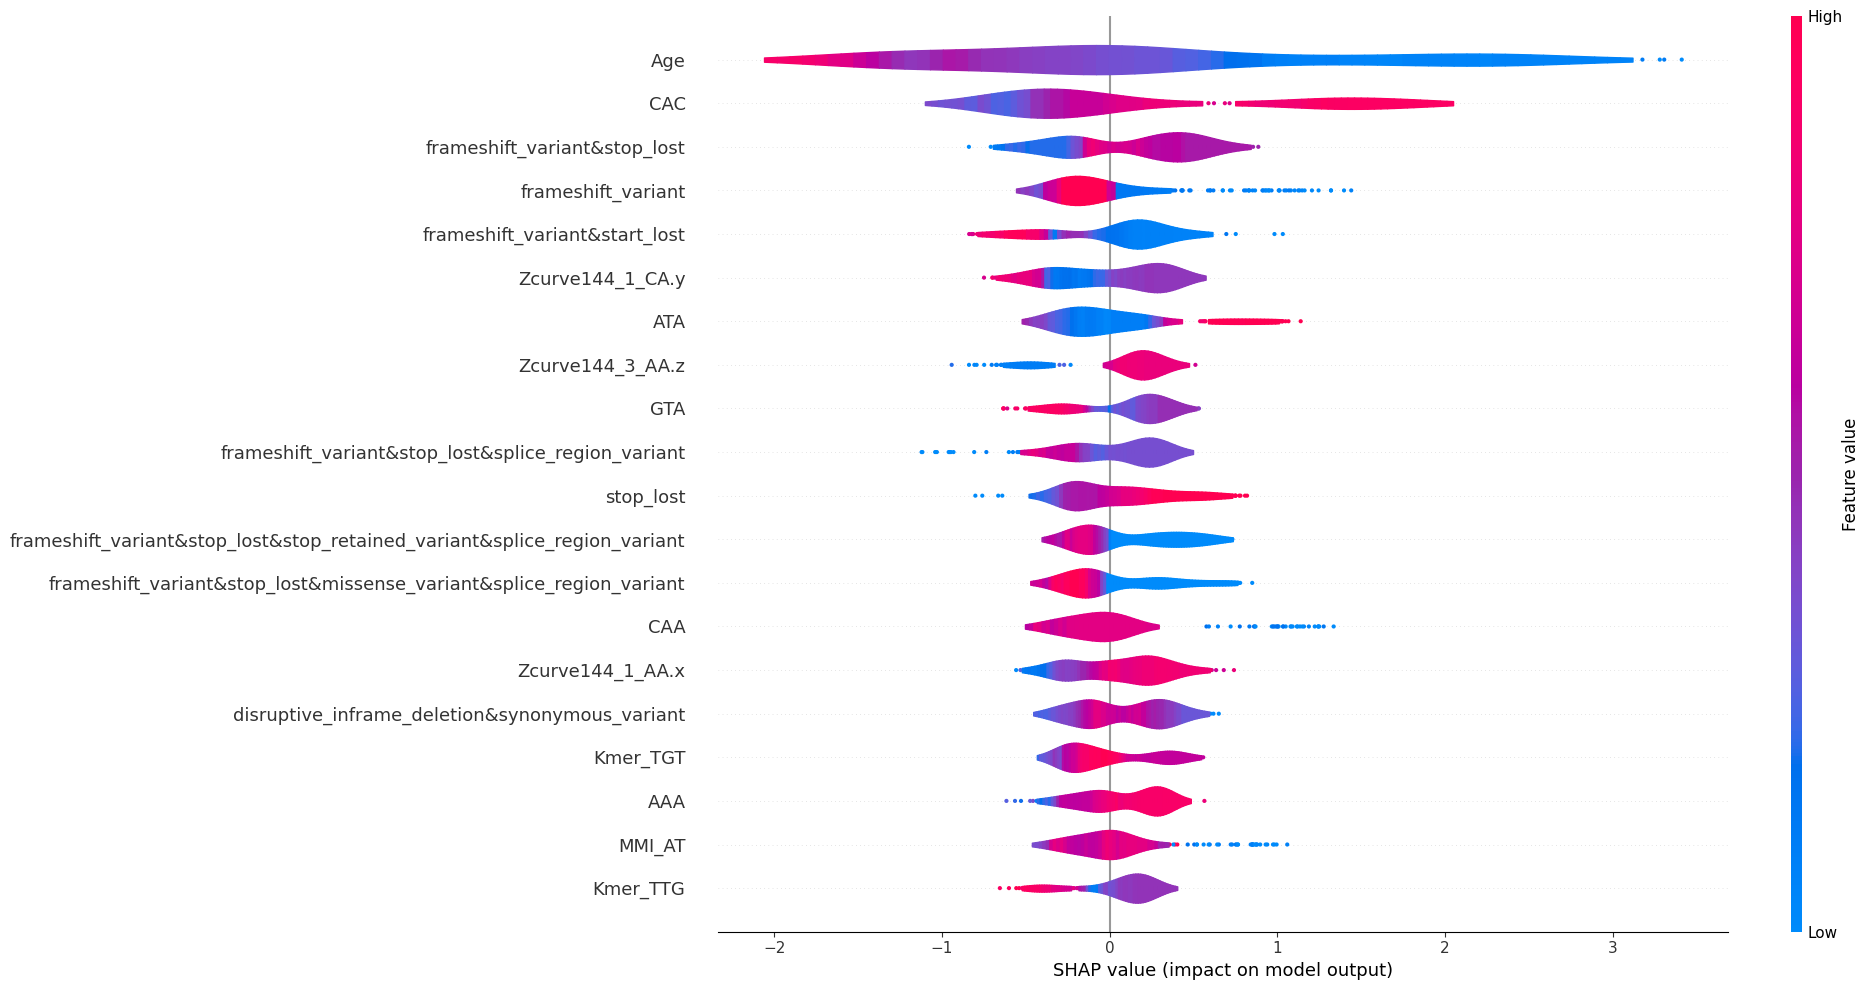

In [12]:
# SHAP global explanation
explainer = shap.TreeExplainer(xgb_calibrated_model.estimator.named_steps['classifier']) # Create SHAP explainer for the XGBoost model
shap_values = explainer.shap_values(X_test_reduced) # Compute SHAP values for the test set
shap.summary_plot(shap_values, X_test_reduced, plot_size=(20, 10), plot_type="violin", show=False)
plt.savefig("../results/2025-07-07_XGB_shap_summary_plot.png", dpi=1200, bbox_inches='tight')

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, classifier_rf__max_depth=5, classifier_rf__min_samples_leaf=6, classifier_rf__min_samples_split=10, classifier_rf__n_estimators=1075; total time=  10.1s
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, classifier_rf__max_depth=5, classifier_rf__min_samples_leaf=6, classifier_rf__min_samples_split=10, classifier_rf__n_estimators=1075; total time=  10.2s
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, classifier_rf__max_depth=5, classifier_rf__min_samples_leaf=6, classifier_rf__min_samples_split=10, classifier_rf__n_estimators=1075; total time=   8.4s
[CV] END classifier_rf__bootstrap=False, classifier_rf__ccp_alpha=0.008916481566215747, classifier_rf__criterion=gini, clas

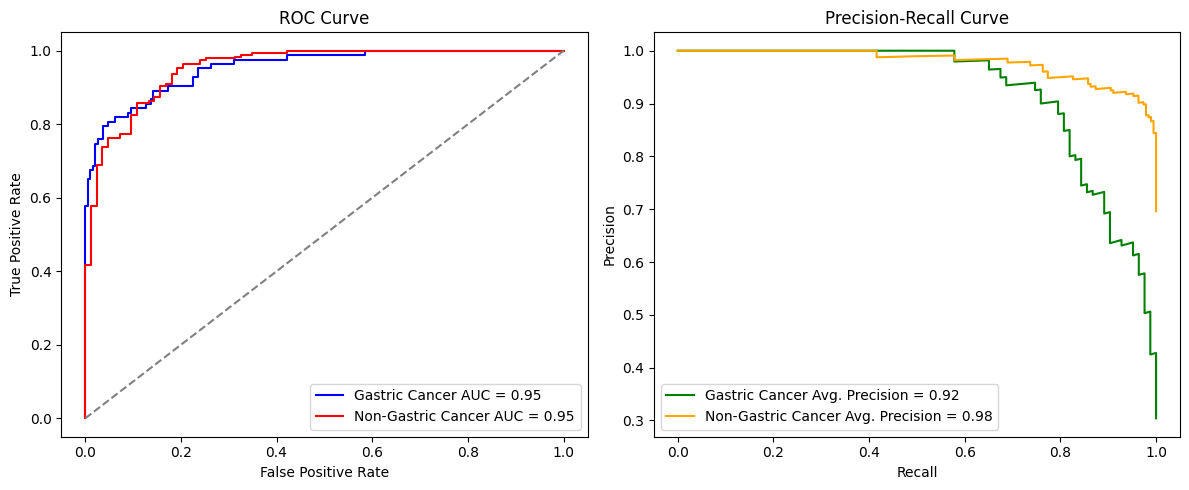

Exception ignored in: <function ResourceTracker.__del__ at 0x7390df8384a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f9da692c4a0>
Traceback (most recent call last):
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/micro/miniforge3/envs/shaprfecv/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProc

In [ ]:
# Random Forest Classifier

# Create the pipeline
rf_pipeline = Pipeline([('smotenc', SMOTENC(categorical_features=categorical_indices_subset, random_state=26)),
    ('classifier_rf', RandomForestClassifier(random_state=26))
])

params_rf_bayes = {
    'classifier_rf__n_estimators': Integer(50, 2000),
    'classifier_rf__criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'classifier_rf__max_depth': Integer(3, 10),
    'classifier_rf__min_samples_split': Integer(2, 10),
    'classifier_rf__min_samples_leaf': Integer(1, 10),
    'classifier_rf__bootstrap': Categorical([True, False]),
    'classifier_rf__ccp_alpha': Real(1e-6, 0.01, prior='log-uniform'),
}

bayes_search_rf = BayesSearchCV(
    estimator=rf_pipeline,
    search_spaces=params_rf_bayes,
    scoring='recall',
    cv=ss,
    n_iter=30,
    n_points=2,
    n_jobs=2,
    verbose=2,
    random_state=26
)
# Fit the model
bayes_search_rf.fit(X_train_reduced, y_train_set_encoded)

# Get predictions
y_test_pred_rf = bayes_search_rf.predict(X_test_reduced)

# Generate the classification report as a dictionary
report_dict_rf = classification_report(
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(y_test_pred_rf),
    output_dict=True
)

# Convert to DataFrame
report_df_rf = pd.DataFrame(report_dict_rf).transpose()

# Save to CSV
report_df_rf.to_csv("../results/2025-07-07_RF_before_calibration_classification_report.csv", index=True)


rf_calibrated_model = CalibratedClassifierCV(bayes_search_rf.best_estimator_, method='sigmoid', cv=ss)
rf_calibrated_model.fit(X_train_reduced, y_train_set_encoded)

# Get predictions
rf_y_test_pred_calibrated = rf_calibrated_model.predict(X_test_reduced)

# Generate the classification report as a dictionary
rf_report_dict_calibrated = classification_report(
    le.inverse_transform(y_test_set_encoded),
    le.inverse_transform(rf_y_test_pred_calibrated),
    output_dict=True
)

# Convert to DataFrame
rf_report_df_calibrated = pd.DataFrame(rf_report_dict_calibrated).transpose()

# Save to CSV
rf_report_df_calibrated.to_csv("../results/2025-07-07_RF_after_calibration_classification_report.csv", index=True)

y_proba_test_0 = rf_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
y_proba_test_1 = rf_calibrated_model.predict_proba(X_test_reduced)[:, 1] # Non-Gastric Cancer
# ROC Curve
fpr_0, tpr_0, _ = roc_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
fpr_1, tpr_1, _ = roc_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)

roc_auc_0 = auc(fpr_0, tpr_0)
roc_auc_1 = auc(fpr_1, tpr_1)
# PR Curve
precision_0, recall_0, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_0, pos_label=0)
pr_auc_0 = average_precision_score(y_test_set_encoded, y_proba_test_0, pos_label=0, average='weighted')

precision_1, recall_1, _ = precision_recall_curve(y_test_set_encoded, y_proba_test_1, pos_label=1)
pr_auc_1 = average_precision_score(y_test_set_encoded, y_proba_test_1, pos_label=1, average='weighted')
# Plotting
plt.figure(figsize=(12, 5))

# ROC Plot
plt.subplot(1, 2, 1)
plt.plot(fpr_0, tpr_0, color='blue', label=f"Gastric Cancer AUC = {roc_auc_0:.2f}")
plt.plot(fpr_1, tpr_1, color='red', label=f"Non-Gastric Cancer AUC = {roc_auc_1:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Plot
plt.subplot(1, 2, 2)
plt.plot(recall_0, precision_0, color='green', label=f"Gastric Cancer Avg. Precision = {pr_auc_0:.2f}")
plt.plot(recall_1, precision_1, color='orange', label=f"Non-Gastric Cancer Avg. Precision = {pr_auc_1:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.savefig("../results/2025-07-12_RF_after_calibration_ROC_PR_curves.png", dpi=1200)
plt.show()

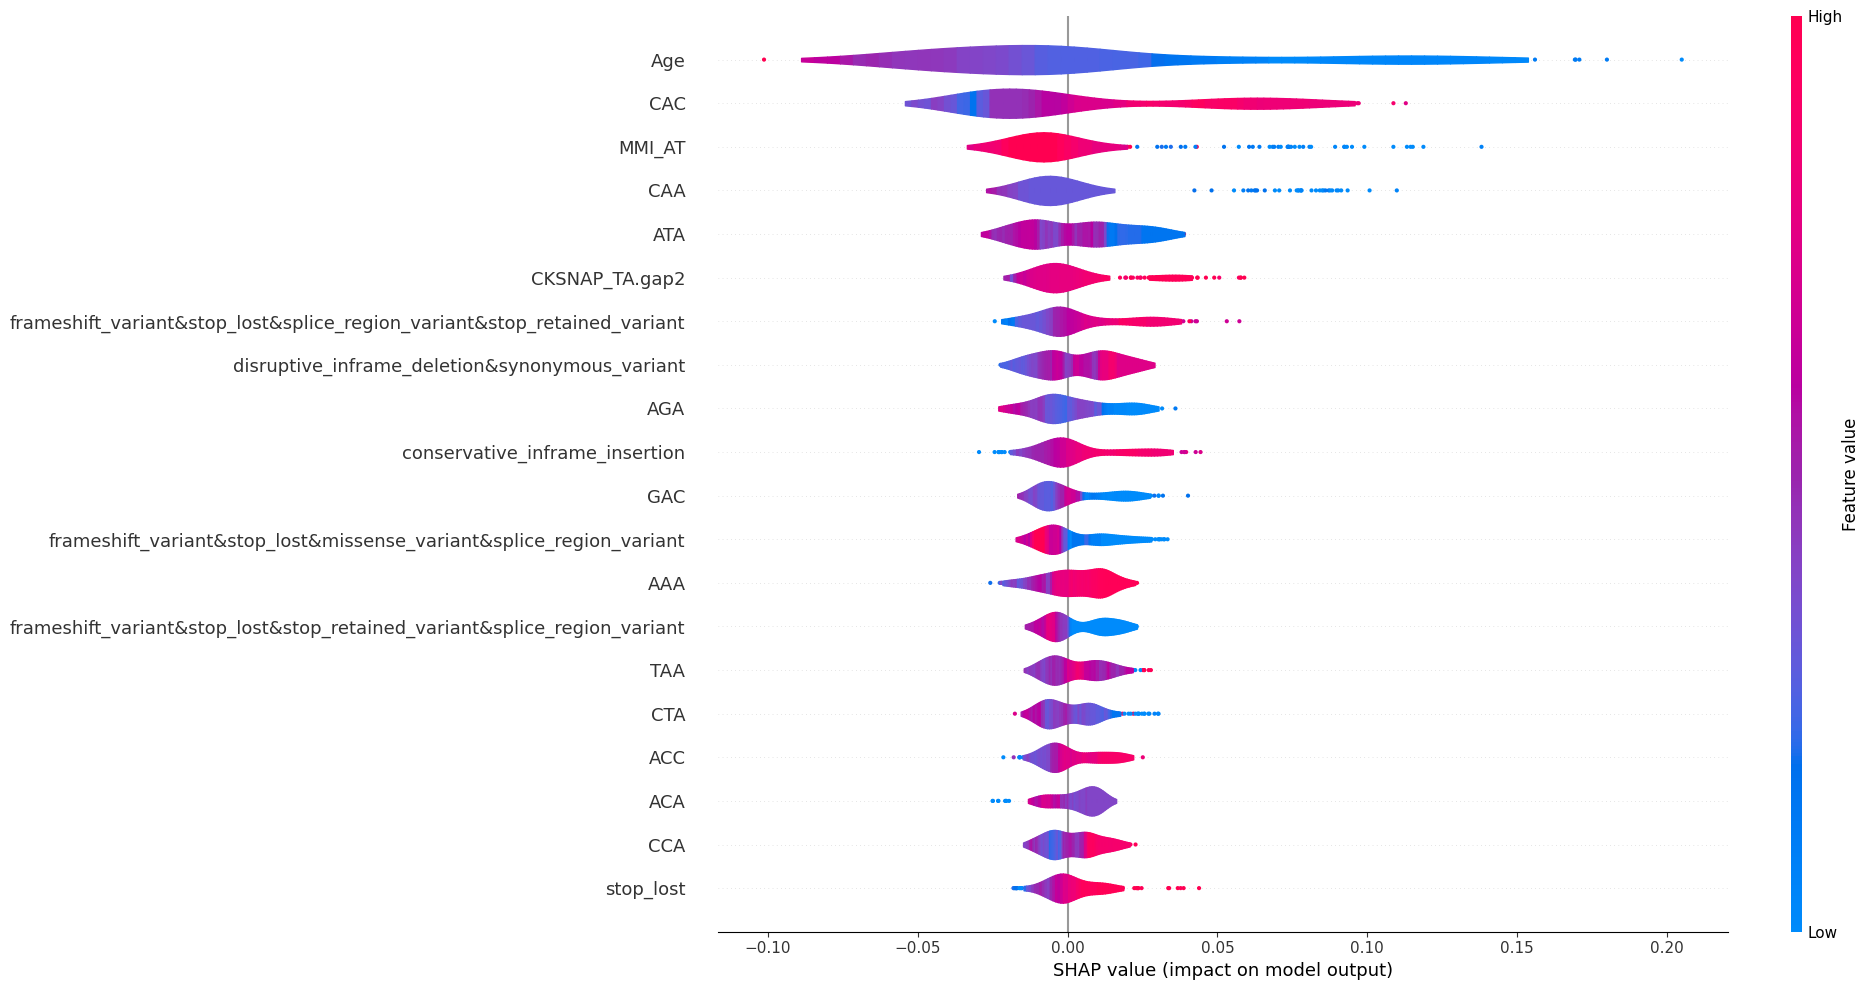

In [14]:
rf_explainer = shap.TreeExplainer(rf_calibrated_model.estimator.named_steps['classifier_rf']) # Create SHAP explainer for the Random Forest model
rf_shap_values = rf_explainer.shap_values(X_test_reduced)
shap.summary_plot(rf_shap_values[:,:,1], X_test_reduced, plot_size=(20, 10), plot_type="violin", show=False)
plt.savefig("../results/2025-07-12_RF_after_calibration_shap_summary_plot.png", dpi=1200)

In [17]:
# DeLong's test for comparing AUCs
from MLstatkit.stats import Delong_test

true = y_test_set_encoded
prob_A = xgb_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
prob_B = lr_pipeline.predict_proba(X_test_set_encoded)[:, 0] # Gastric Cancer

# DeLong's test
z_score, p_value = Delong_test(true, prob_A, prob_B)
print(f"Z-score: {z_score}, P-value: {p_value}")

Z-score: -3.1352559060615994, P-value: 0.0017170425543178239


In [21]:
# DeLong's test for comparing AUCs
from MLstatkit.stats import Delong_test

true = y_test_set_encoded
prob_A = rf_calibrated_model.predict_proba(X_test_reduced)[:, 0] # Gastric Cancer
prob_B = lr_pipeline.predict_proba(X_test_set_encoded)[:, 0] # Gastric Cancer

# DeLong's test
z_score, p_value = Delong_test(true, prob_A, prob_B)
print(f"Z-score: {z_score}, P-value: {p_value}")

Z-score: -3.2085019288115304, P-value: 0.001334284142251791
